# 1. Introduction

MOCHIS is a software that allows the user to perform flexible non-parametric tests of differential gene expression. Such tests include the popular Mann-Whitney (Wilcoxon rank sum) test, which was recently promoted by Li et al. (2022) as an approach to perform differential analysis on RNA-seq data without incurring an inflated false positive rate.
In this markdown document, we explore how MOCHIS can detect multiple kinds of differential gene expression signatures, including mean shifts or dispersion shifts. Dispersion shifts have recently been shown to characterize age-related changes in gene expression (see Schaum et al., 2020 and Yamamoto and Chung et al., 2022+). In particular, we:
- perform multiple kinds of two-sample tests on all single-cell tissue data provided in Tabula muris senis 
- report and compare findings across the different kinds of tests
For Section 3 (Analysis), all our analyses are followed by a summary of key findings, to help the reader quickly grasp the main points.


In [156]:
# Setup

import scanpy
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from main_draft0 import *
import scipy
import statistics
import csv
import os
import seaborn as sns
from matplotlib_venn import venn2
import math

np.random.seed(2022)
scipy.__version__

'1.8.0'

# 2. Data
Publicly available _mus musculus_ (house mice) single-cell RNA-seq data from the Chan-Zuckerberg Initiative (also known as _Tabula Muris Senis_) is used. We download senescence datasets from [here](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb). These datasets are made up of single cell gene transcript levels measured using Smart-Seq2, across $22$ distinct mice tissues. For each tissue, the cells originate from mice that are either 3 months, 18 months or 24 months old (with the exception of the mammary gland tissue, which has 3 months, 18 months and 21 months). There are also other cell labels like tissue location (identified with guidance from biologists) and mice sex.

Below, we perform the Mann-Whitney test to identify genes that are differentially expressed, also known as differentially expressed genes (DEGs), across age groups. We compare each pair of age group, so that for each gene ${3\choose 2}=3$ tests are performed. 

We restrict our analysis to those regions where the zero counts are the fewest, using an $80\%$ cut-off. This avoids running tests on genes that have pronounced zero inflation, which hinders the detection of differential expression. 

We additionally compute a "ratio of variances" index, which heuristic measures of the difference in dispersion across the pair of age groups. The larger the ratio of variances, the more differentially dispersed the gene expression between the pair of age groups.

In [2]:
# Perform analysis for each tissue
# There are 22 tissues
all_tissues = sorted(["bone-marrow",
              "brain-myeloid",
              "heart",
              "large-intestine",
              "lung",
              "skin-of-body",
              "thymus",
              "limb-muscle",
              "spleen",
              "subcutaneous-adipose-tissue",
              "tongue",
              "gonadal-fat-pad",
              "pancreas",
              "mammary-gland",
              "trachea",
              "mesenteric-fat-pad",
              "liver",
              "bladder-lumen",
              "brown-adipose-tissue",
              "diaphragm",
              "kidney",
              "aorta"])


for tissue in all_tissues:
    #os.mkdir(os.path.join("tissues/", tissue))
    
        
    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].index)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
    #print(smartseq2_raw_counts.shape)  # 14517 mice cells x 21069 regions
    
    # Get cutoff and restrict to only those genes
    cutoff = round(0.8*smartseq2_raw_counts.shape[0])
    
    cell_count_sums_by_region = np.count_nonzero(smartseq2_raw_counts, axis=0)

    highly_expressed_genes_indices = [i for i,v in enumerate(cell_count_sums_by_region) if v > cutoff] # row_ids
  
    smartseq2_high_exp_sparse_mat = []
    for i in highly_expressed_genes_indices:
        smartseq2_high_exp_sparse_mat.append(smartseq2_raw_counts[:, i])
    
    print("Found ", len(highly_expressed_genes_indices), " genes out of ", smartseq2_raw_counts.shape[0], " genes meeting the cutoff threshold...")

    highly_expressed_transcripts = [transcripts[i] for i in highly_expressed_genes_indices]

    # Grab age labels
    #smartseq2_df = anndata.AnnData(np.transpose(smartseq2_high_exp_sparse_mat), pd.DataFrame(ages, columns=['ages']), pd.DataFrame(highly_expressed_transcripts, columns=['highly_expressed_transcripts']) )
    smartseq2_df = pd.DataFrame(np.append(np.transpose(smartseq2_high_exp_sparse_mat),[[i] for i in tissue_smartseq2_data.obs['age'].values], axis=1), columns = highly_expressed_transcripts + ['ages'])

    # Run Mann-Whitney test for genes
    gene_names = smartseq2_df.columns.values[:-1]
    results_df = pd.DataFrame(columns=['TRANSCRIPT', 'MANN_WHITNEY_3_18', 'MANN_WHITNEY_18_24', 'MANN_WHITNEY_24_3', 'VAR_3_18', 'VAR_18_24', 'VAR_24_3'])
    
    print("How many cells of each age group?")
    print(smartseq2_df['ages'].value_counts())
    
    
    # Run test for each gene
    for i in range(len(gene_names)):
        to_run_test = smartseq2_df[[gene_names[i], 'ages']]
        
        if tissue == "mammary-gland":
            print("Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...")
            age_3m = to_run_test.loc[to_run_test["ages"] == "3m", gene_names[i]].values
            age_18m = to_run_test.loc[to_run_test["ages"] == "18m", gene_names[i]].values
            age_24m = to_run_test.loc[to_run_test["ages"] == "21m", gene_names[i]].values
        else:
            age_3m = to_run_test.loc[to_run_test["ages"] == "3m", gene_names[i]].values
            age_18m = to_run_test.loc[to_run_test["ages"] == "18m", gene_names[i]].values
            age_24m = to_run_test.loc[to_run_test["ages"] == "24m", gene_names[i]].values
            
        age_3m = [float(i) for i in age_3m]
        age_18m = [float(i) for i in age_18m]
        age_24m = [float(i) for i in age_24m]
        
        wrs_test_3_18 = scipy.stats.mannwhitneyu(x=age_3m, y=age_18m, alternative='two-sided')
        wrs_test_18_24 = scipy.stats.mannwhitneyu(x=age_18m, y=age_24m, alternative='two-sided')
        wrs_test_24_3 = scipy.stats.mannwhitneyu(x=age_3m, y=age_24m, alternative='two-sided')
        
        var_3_18 = max(statistics.variance(age_3m)/statistics.variance(age_18m), statistics.variance(age_18m)/statistics.variance(age_3m))
        var_18_24 = max(statistics.variance(age_18m)/statistics.variance(age_24m),statistics.variance(age_24m)/statistics.variance(age_18m))
        var_24_3 = max(statistics.variance(age_24m)/statistics.variance(age_3m),statistics.variance(age_3m)/statistics.variance(age_24m))
        
        results_df = results_df.append({
            'TRANSCRIPT': gene_names[i],
            'MANN_WHITNEY_3_18': wrs_test_3_18.pvalue,
            'MANN_WHITNEY_18_24': wrs_test_18_24.pvalue,
            'MANN_WHITNEY_24_3': wrs_test_24_3.pvalue,
            'VAR_3_18': var_3_18,
            'VAR_18_24': var_18_24,
            'VAR_24_3': var_24_3
        }, ignore_index=True)
        
        
        
        
    print("Saving results for ", tissue)
    results_df.to_csv("tissues/"+tissue+"/p_val_table.csv")

        
        
        
    
    
    

Found  109  genes out of  906  genes meeting the cutoff threshold...
How many cells of each age group?
3m     366
18m    316
24m    224
Name: ages, dtype: int64
Saving results for  aorta
Found  1039  genes out of  2432  genes meeting the cutoff threshold...
How many cells of each age group?
3m     1306
18m     692
24m     434
Name: ages, dtype: int64
Saving results for  bladder-lumen
Found  198  genes out of  14517  genes meeting the cutoff threshold...
How many cells of each age group?
3m     5069
18m    4784
24m    4664
Name: ages, dtype: int64
Saving results for  bone-marrow
Found  177  genes out of  13417  genes meeting the cutoff threshold...
How many cells of each age group?
3m     4532
18m    4461
24m    4424
Name: ages, dtype: int64
Saving results for  brain-myeloid
Found  87  genes out of  2223  genes meeting the cutoff threshold...
How many cells of each age group?
24m    848
3m     713
18m    662
Name: ages, dtype: int64
Saving results for  brown-adipose-tissue
Found  162  g

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Reminder that mammary-gland has 3m, 18m and

## 2.1 Mann-Whitney DEGs

Given we have the tables of $p$-values and ratios of variances from the previous step, we now select genes whose $p$-values, after a Benjamini-Hochberg adjustment procedure, lie below or equal to a $0.05$ significance level. These are Mann-Whitney significant genes that would be flagged as potentially carrying biological signal in a typical differential expression analysis procedure.

In [3]:
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

In [4]:
tissue_transcript_3_18 = pd.DataFrame(columns=['TRANSCRIPT', 'MANN_WHITNEY', 'VARIANCE_RATIO', 'TISSUE'])
tissue_transcript_18_24 = pd.DataFrame(columns=['TRANSCRIPT', 'MANN_WHITNEY', 'VARIANCE_RATIO', 'TISSUE'])
tissue_transcript_24_3 = pd.DataFrame(columns=['TRANSCRIPT', 'MANN_WHITNEY', 'VARIANCE_RATIO', 'TISSUE'])


for tissue in all_tissues:
    print("Reading in summary of p-values and ratios of variances for ", tissue)
    tissue_mann_whitney_df = pd.read_csv("tissues/"+tissue+"/p_val_table.csv")
    
    # Pick genes where one of the three pairs (3m, 18m, 24m) has significant p-value at FDR 0.05 control
    selected_genes_3_18 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MANN_WHITNEY_3_18']) <= 0.05]
    selected_genes_3_18 = selected_genes_3_18[["TRANSCRIPT", "MANN_WHITNEY_3_18", "VAR_3_18"]]
    selected_genes_3_18= selected_genes_3_18.rename(columns={"MANN_WHITNEY_3_18":"MANN_WHITNEY", "VAR_3_18":"VARIANCE_RATIO"})
    selected_genes_3_18["TISSUE"] = [tissue for i in range(selected_genes_3_18.shape[0])]
    tissue_transcript_3_18 = pd.concat([tissue_transcript_3_18, selected_genes_3_18])
    
    selected_genes_18_24 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MANN_WHITNEY_18_24']) <= 0.05]
    selected_genes_18_24 = selected_genes_18_24[["TRANSCRIPT", "MANN_WHITNEY_18_24", "VAR_18_24"]]
    selected_genes_18_24 = selected_genes_18_24.rename(columns={"MANN_WHITNEY_18_24":"MANN_WHITNEY", "VAR_18_24":"VARIANCE_RATIO"})
    selected_genes_18_24["TISSUE"] = [tissue for i in range(selected_genes_18_24.shape[0])]
    tissue_transcript_18_24 = pd.concat([tissue_transcript_18_24, selected_genes_18_24])
    
    selected_genes_24_3 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MANN_WHITNEY_24_3']) <= 0.05]
    selected_genes_24_3 = selected_genes_24_3[["TRANSCRIPT", "MANN_WHITNEY_24_3", "VAR_24_3"]]
    selected_genes_24_3 = selected_genes_24_3.rename(columns={"MANN_WHITNEY_24_3":"MANN_WHITNEY", "VAR_24_3":"VARIANCE_RATIO"})
    selected_genes_24_3["TISSUE"] = [tissue for i in range(selected_genes_24_3.shape[0])]
    tissue_transcript_24_3 = pd.concat([tissue_transcript_24_3, selected_genes_24_3])
    
tissue_transcript_3_18.to_csv("tissues/mw_sig_3m_18m.csv")
tissue_transcript_18_24.to_csv("tissues/mw_sig_18m_24m.csv")
tissue_transcript_24_3.to_csv("tissues/mw_sig_24m_3m.csv")
    






Reading in summary of p-values and ratios of variances for  aorta
Reading in summary of p-values and ratios of variances for  bladder-lumen
Reading in summary of p-values and ratios of variances for  bone-marrow
Reading in summary of p-values and ratios of variances for  brain-myeloid
Reading in summary of p-values and ratios of variances for  brown-adipose-tissue
Reading in summary of p-values and ratios of variances for  diaphragm
Reading in summary of p-values and ratios of variances for  gonadal-fat-pad
Reading in summary of p-values and ratios of variances for  heart
Reading in summary of p-values and ratios of variances for  kidney
Reading in summary of p-values and ratios of variances for  large-intestine
Reading in summary of p-values and ratios of variances for  limb-muscle
Reading in summary of p-values and ratios of variances for  liver
Reading in summary of p-values and ratios of variances for  lung
Reading in summary of p-values and ratios of variances for  mammary-gland
R

Let us visualize the raw $p$-values and variance ratios of the Mann-Whitney DEGs fished out from the above procedure. 

In [5]:
df_3_18 = pd.read_csv("tissues/mw_sig_3m_18m.csv")
df_18_24 = pd.read_csv("tissues/mw_sig_18m_24m.csv")
df_24_3 = pd.read_csv("tissues/mw_sig_24m_3m.csv")


df_3_18["PAIR"] = ["3m vs 18m" for i in range(df_3_18.shape[0])]
df_18_24["PAIR"] = ["18m vs 24m" for i in range(df_18_24.shape[0])]
df_24_3["PAIR"] = ["3m vs 24m" for i in range(df_24_3.shape[0])]



'''
groups = df_3_18.groupby("TISSUE")
for name, group in groups:
    plt.plot(group["MANN_WHITNEY"], group["VARIANCE_RATIO"], marker="o", linestyle="", label=name, alpha=0.5)
plt.legend()

groups = df_18_24.groupby("TISSUE")
for name, group in groups:
    plt.plot(group["MANN_WHITNEY"], group["VARIANCE_RATIO"], marker="o", linestyle="", label=name, alpha=0.5)
plt.legend()

groups = df_24_3.groupby("TISSUE")
for name, group in groups:
    plt.plot(group["MANN_WHITNEY"], group["VARIANCE_RATIO"], marker="o", linestyle="", label=name, alpha=0.5)
plt.legend()


grand_df = pd.concat(pd.concat(df_3_18, df_18_24), df_24_3)

g = sns.FacetGrid([grand_df], col="PAIR")
g.map(sns.scatterplot, x='MANN_WHITNEY', y='VARIANCE_RATIO', hue='TISSUE', alpha=0.5)

#sns.scatterplot(data=grand_df, x='MANN_WHITNEY', y='VARIANCE_RATIO', hue='TISSUE', alpha=0.5).FacetGrid

sns.scatterplot(data=df_3_18, x='MANN_WHITNEY', y='VARIANCE_RATIO', hue='TISSUE')
sns.show()
sns.scatterplot(data=df_3_18, x='MANN_WHITNEY', y='VARIANCE_RATIO', hue='TISSUE')
'''




'\ngroups = df_3_18.groupby("TISSUE")\nfor name, group in groups:\n    plt.plot(group["MANN_WHITNEY"], group["VARIANCE_RATIO"], marker="o", linestyle="", label=name, alpha=0.5)\nplt.legend()\n\ngroups = df_18_24.groupby("TISSUE")\nfor name, group in groups:\n    plt.plot(group["MANN_WHITNEY"], group["VARIANCE_RATIO"], marker="o", linestyle="", label=name, alpha=0.5)\nplt.legend()\n\ngroups = df_24_3.groupby("TISSUE")\nfor name, group in groups:\n    plt.plot(group["MANN_WHITNEY"], group["VARIANCE_RATIO"], marker="o", linestyle="", label=name, alpha=0.5)\nplt.legend()\n\n\ngrand_df = pd.concat(pd.concat(df_3_18, df_18_24), df_24_3)\n\ng = sns.FacetGrid([grand_df], col="PAIR")\ng.map(sns.scatterplot, x=\'MANN_WHITNEY\', y=\'VARIANCE_RATIO\', hue=\'TISSUE\', alpha=0.5)\n\n#sns.scatterplot(data=grand_df, x=\'MANN_WHITNEY\', y=\'VARIANCE_RATIO\', hue=\'TISSUE\', alpha=0.5).FacetGrid\n\nsns.scatterplot(data=df_3_18, x=\'MANN_WHITNEY\', y=\'VARIANCE_RATIO\', hue=\'TISSUE\')\nsns.show()\nsns.s

<AxesSubplot:xlabel='MANN_WHITNEY', ylabel='VARIANCE_RATIO'>

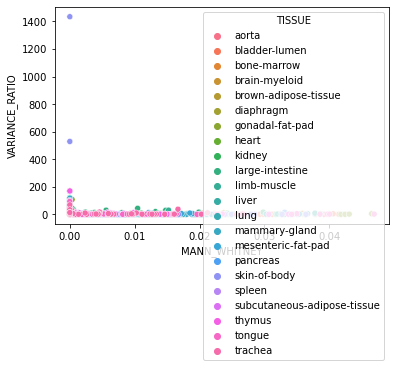

In [6]:
sns.scatterplot(data=df_18_24, x='MANN_WHITNEY', y='VARIANCE_RATIO', hue='TISSUE')

<AxesSubplot:xlabel='MANN_WHITNEY', ylabel='VARIANCE_RATIO'>

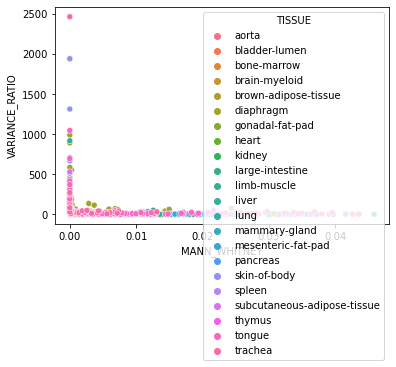

In [7]:
sns.scatterplot(data=df_3_18, x='MANN_WHITNEY', y='VARIANCE_RATIO', hue='TISSUE')

<AxesSubplot:xlabel='MANN_WHITNEY', ylabel='VARIANCE_RATIO'>

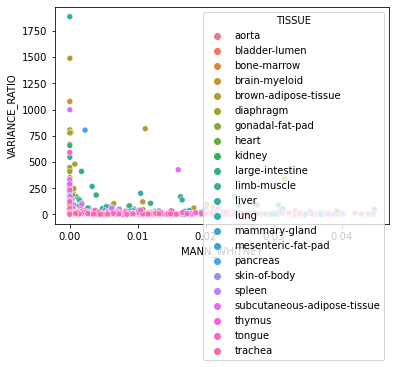

In [8]:
sns.scatterplot(data=df_24_3, x='MANN_WHITNEY', y='VARIANCE_RATIO', hue='TISSUE')

Next we look at the distribution, across tissues, of Mann-Whitney significant genes.

In [9]:
print("No. MW significant genes for 3m vs 18m: ", df_3_18.shape[0])
print("No. MW significant genes for 18m vs 24m: ", df_18_24.shape[0])
print("No. MW significant genes for 24m vs 3m: ", df_24_3.shape[0])



No. MW significant genes for 3m vs 18m:  5571
No. MW significant genes for 18m vs 24m:  5305
No. MW significant genes for 24m vs 3m:  5634


<AxesSubplot:ylabel='None'>

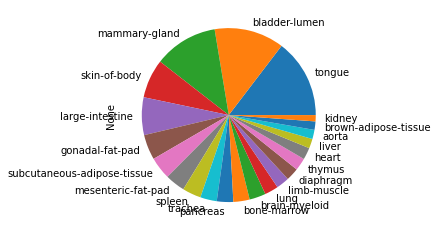

In [10]:
df_3_18.value_counts("TISSUE").plot(kind="pie")

<AxesSubplot:ylabel='None'>

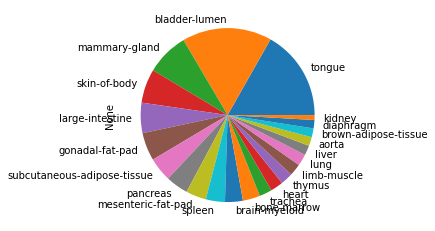

In [11]:
df_18_24.value_counts("TISSUE").plot(kind="pie")

<AxesSubplot:ylabel='None'>

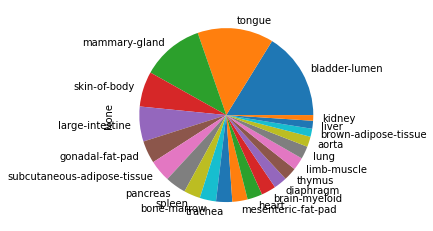

In [12]:
df_24_3.value_counts("TISSUE").plot(kind="pie")

## 2.2 MOCHIS

We now repeat the DEG identification procedure above, now using our flexible non-parametric testing software MOCHIS. We run MOCHIS with test statistic $||S_{n,k}||_{p,\boldsymbol{w}}^p$. We choose the following parametrization:

- $p=1$
- $\boldsymbol{w}=\left((\frac{j}{k} - \frac{1}{2})^2:j = 1,\ldots,k\right)$

This parametrization optimizes detection of dispersion shifts between two samples. 

**Step 1.** Compute $p$-values.

When computing the $p$-values, we apply a tie-breaking routine (adding noise ranging from $-0.25$ to $0.25$, which is less than the minimum spacing width of integer counts). To ensure that this routine does not overly contaminate the data, we also compute Mann-Whitney $p$-values and check that the Mann-Whitney DEGs identified after applying the tie-breaking routine are not markedly different from the original DEGs identified in Section 2.1. We report this latter comparison between post-contamination and original DEGs in Section 2.3. (Heads up: We find little difference.)  

In [14]:
for tissue in all_tissues:
    

    #os.mkdir(os.path.join("tissues/", tissue))
    
    
        
    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].index)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
    print(smartseq2_raw_counts.shape)  # 14517 mice cells x 21069 regions
    
    # Get cutoff and restrict to only those genes
    cutoff = round(0.8*smartseq2_raw_counts.shape[0])
    
    cell_count_sums_by_region = np.count_nonzero(smartseq2_raw_counts, axis=0)

    highly_expressed_genes_indices = [i for i,v in enumerate(cell_count_sums_by_region) if v > cutoff] # row_ids
  
    smartseq2_high_exp_sparse_mat = []
    for i in highly_expressed_genes_indices:
        smartseq2_high_exp_sparse_mat.append(smartseq2_raw_counts[:, i])
    
    print("Found ", len(highly_expressed_genes_indices), " genes out of ", smartseq2_raw_counts.shape[0], " genes meeting the cutoff threshold...")

    highly_expressed_transcripts = [transcripts[i] for i in highly_expressed_genes_indices]

    # Grab age labels
    #smartseq2_df = anndata.AnnData(np.transpose(smartseq2_high_exp_sparse_mat), pd.DataFrame(ages, columns=['ages']), pd.DataFrame(highly_expressed_transcripts, columns=['highly_expressed_transcripts']) )
    smartseq2_df = pd.DataFrame(np.append(np.transpose(smartseq2_high_exp_sparse_mat),[[i] for i in tissue_smartseq2_data.obs['age'].values], axis=1), columns = highly_expressed_transcripts + ['ages'])
    
    
    # Run Mann-Whitney test for genes
    gene_names = smartseq2_df.columns.values[:-1]
    results_df = pd.DataFrame(columns=['TRANSCRIPT', 
                                       'MOCHIS_3_18', 
                                       'MW_3_18', 
                                       'MOCHIS_18_24', 
                                       'MW_18_24', 
                                       'MOCHIS_24_3', 
                                       'MW_24_3', 
                                       'VAR_3_18', 
                                       'INV_3_18',
                                       'VAR_18_24',
                                       'INV_18_24',
                                       'VAR_24_3',
                                       'INV_24_3'])
    print("How many cells of each age group?")
    print(smartseq2_df['ages'].value_counts())
    
    # Run test for each gene
    for i in range(len(gene_names)):
        to_run_test = smartseq2_df[[gene_names[i], 'ages']]
        
        if tissue == "mammary-gland":
            print("Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...")
            age_3m = to_run_test.loc[to_run_test["ages"] == "3m", gene_names[i]].values
            age_18m = to_run_test.loc[to_run_test["ages"] == "18m", gene_names[i]].values
            age_24m = to_run_test.loc[to_run_test["ages"] == "21m", gene_names[i]].values
        else:
            age_3m = to_run_test.loc[to_run_test["ages"] == "3m", gene_names[i]].values
            age_18m = to_run_test.loc[to_run_test["ages"] == "18m", gene_names[i]].values
            age_24m = to_run_test.loc[to_run_test["ages"] == "24m", gene_names[i]].values
            
        age_3m = [float(i) for i in age_3m]
        age_18m = [float(i) for i in age_18m]
        age_24m = [float(i) for i in age_24m]
        
        
        # Add noise to break ties
        
        noisy_age_3m = np.sort([value + np.random.uniform(-1/4, 1/4) for value in age_3m])
        noisy_age_18m = np.sort([value + np.random.uniform(-1/4, 1/4) for value in age_18m])
        noisy_age_24m = np.sort([value + np.random.uniform(-1/4, 1/4) for value in age_24m])
        
        
        wrs_test_3_18 = scipy.stats.mannwhitneyu(x=noisy_age_3m, y=noisy_age_18m, use_continuity=False,  method='asymptotic')
        wrs_test_18_24 = scipy.stats.mannwhitneyu(x=noisy_age_18m, y=noisy_age_24m, use_continuity=False,  method='asymptotic')
        wrs_test_24_3 = scipy.stats.mannwhitneyu(x=noisy_age_3m, y=noisy_age_24m, use_continuity=False,  method='asymptotic')
        
        
        
        
        if len(noisy_age_3m) > len(noisy_age_18m):
            #print("3 > 18")
            
            k = len(age_18m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_3_18 = mochis_py(x = noisy_age_18m,
                                         p = 1,
                                         wList = mochis_weights,
                                         alternative = "two.sided",
                                         approx = "chebyshev",
                                         n_mom = 100,
                                         y = noisy_age_3m)
            
        else:
            #print(" 18 > 3")
            
            k = len(age_3m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_3_18 = mochis_py(x = noisy_age_3m,
                                         p = 1,
                                         wList = mochis_weights,
                                         alternative = "two.sided",
                                         approx = "chebyshev",
                                         n_mom = 100,
                                         y = noisy_age_18m)

            
            
            
        if len(noisy_age_18m) > len(noisy_age_24m):
            #print("18 > 24")
            
            k = len(noisy_age_24m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_18_24 = mochis_py(x = noisy_age_24m,
                                        p = 1,
                                        wList = mochis_weights,
                                        alternative = "two.sided",
                                        approx = "chebyshev",
                                        n_mom = 100,
                                        y = noisy_age_18m)
            
        else:
            #print("24 > 18")
        
            k = len(noisy_age_18m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_18_24 = mochis_py(x = noisy_age_18m,
                                        p = 1,
                                        wList = mochis_weights,
                                        alternative = "two.sided",
                                        approx = "chebyshev",
                                        n_mom = 100,
                                        y = noisy_age_24m)
            
            
        if len(noisy_age_3m) > len(noisy_age_24m):
            #print("3 > 24")
            
            k = len(noisy_age_24m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_24_3 = mochis_py(x = noisy_age_24m,
                                        p = 1,
                                        wList = mochis_weights,
                                        alternative = "two.sided",
                                        approx = "chebyshev",
                                        n_mom = 100,
                                        y = noisy_age_3m)
            
        else:
            #print(" 24 > 3")
            
            k = len(noisy_age_3m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_24_3 = mochis_py(x = noisy_age_3m,
                                        p = 1,
                                        wList = mochis_weights,
                                        alternative = "two.sided",
                                        approx = "chebyshev",
                                        n_mom = 100,
                                        y = noisy_age_24m)
            
        
        
        var_3_18 = max(statistics.variance(age_3m)/statistics.variance(age_18m), statistics.variance(age_18m)/statistics.variance(age_3m))
        var_18_24 = max(statistics.variance(age_18m)/statistics.variance(age_24m),statistics.variance(age_24m)/statistics.variance(age_18m))
        var_24_3 = max(statistics.variance(age_24m)/statistics.variance(age_3m),statistics.variance(age_3m)/statistics.variance(age_24m))
        
        invert_3_18 = False
        invert_18_24 = False
        invert_24_3 = False
        if var_3_18 == statistics.variance(age_3m)/statistics.variance(age_18m):
            invert_3_18 = True
        if var_18_24 == statistics.variance(age_18m)/statistics.variance(age_24m):
            invert_18_24 = True
        if var_24_3 == statistics.variance(age_3m)/statistics.variance(age_24m):
            invert_24_3 = True
        
        results_df = pd.concat([results_df, pd.DataFrame([{
            "TRANSCRIPT": gene_names[i],
            "MOCHIS_3_18": mochis_test_3_18,
            "MW_3_18": wrs_test_3_18.pvalue,
            "MOCHIS_18_24": mochis_test_18_24,
            "MW_18_24": wrs_test_18_24.pvalue,
            "MOCHIS_24_3": mochis_test_24_3,
            "MW_24_3": wrs_test_24_3.pvalue,
            "VAR_3_18": var_3_18,
            "INV_3_18": invert_3_18,
            "VAR_18_24": var_18_24,
            "INV_18_24": invert_18_24,
            "VAR_24_3": var_24_3,
            "INV_24_3": invert_24_3
        }])])
    
    print("Saving results for ", tissue)
    results_df.to_csv("tissues/"+tissue+"/mochis_p_val_table.csv")
    
    
        
        
        
        
        
    
    
    

(906, 21069)
Found  109  genes out of  906  genes meeting the cutoff threshold...
How many cells of each age group?
3m     366
18m    316
24m    224
Name: ages, dtype: int64
Normalizing weight vector...
The test statistic for the data is  0.17713463132495225
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28928845132051884
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1840964986844769
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2803294621541101
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23241

Normalizing weight vector...
The test statistic for the data is  0.27526722197307624
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32235611814345977
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33214965931322954
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22979537167078132
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3000201281450227
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.28068140236864686
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29205288326300993
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3227920933684141
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2964375787100533
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2719902484763245
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.18895943100533472
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32983728707610527
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3778179315927952
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30937910339750113
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29340259415533676
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.2690079935345667
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2757113298952961
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2584699993253727
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26699988966522004
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3092895764963277
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.2635307336197036
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3277639631192374
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3030277811509142
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1852690616111259
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3407214877324581
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

The test statistic for the data is  0.3796922080550499
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2968123580608857
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29378165338334095
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3360432840855426
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31337138442198
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30272655102359736
Sampl

The test statistic for the data is  0.35912663829673624
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1517985037604774
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3405268371063288
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14291754652500724
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2957835103642335
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39026583180405056
Sa

Normalizing weight vector...
The test statistic for the data is  0.2047260501481114
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3838475619674717
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25224023111923655
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19788296906227476
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3081397883212405
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.157525956330011
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39772253266098373
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24380229909336382
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1547953922078012
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39510009263523194
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.23293952823993996
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40963574421678906
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28879957479498963
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3319925344878443
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4029924616457305
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2659007093617912
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34840552084598214
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27633629313733776
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22247152819337135
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.405158400136853
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.24971706787236844
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36066068088804604
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26875948623354246
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21516519839279255
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3234536674922122
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.22703962811889603
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3795774519889083
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2736067262350237
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24257657853515785
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4478107461450995
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2355915470942354
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39745976324176024
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3650057976063812
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17720377806692708
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.459736787642323
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.32681102127480166
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.55089596521253
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.48016594649287847
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2703795753324071
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2987926261439078
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.33520581144932304
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39919742606937186
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32804458906594297
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17040008441001508
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41071358148578363
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the

Normalizing weight vector...
The test statistic for the data is  0.1631696468380967
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38446773689761327
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23449408069547795
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27684791462361535
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4290779319661811
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.22514723307600687
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3054143421943935
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17887943426853745
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2604134206197278
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39581478146715016
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2409544108462853
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3260560683713686
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2118110524572604
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19879815280993987
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37734791364533044
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2745382143630653
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2875983800671586
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2202777954811648
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3216891886899776
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5976869448472892
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.3061599933115348
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37048652207017196
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35213284945424006
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28163750506186
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5669534922260485
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.20388999839819558
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44637996329720325
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2888575528820407
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1700701254077944
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4975309235954078
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.3662125899610264
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2425697546120768
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.49558737075552334
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4896010627697364
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15156669445565843
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5132120445657182
Sam

Normalizing weight vector...
The test statistic for the data is  0.17240244027698523
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3374879738391385
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2031940390368792
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.125173545676983
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5061355376394594
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.36917827246181895
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4530952157301196
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31790719661907774
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3072144871300285
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35194933395039263
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.20497502767810302
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4157804919213371
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3131872753313723
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2099546803179058
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4440952562055298
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.13473951237718854
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4037603641870515
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18395152954229985
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29741143055648867
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5689888707895074
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.20020372790471505
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38954442252662763
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30968087975515485
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17154678409758198
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4566781296083738
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.1983741001991767
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4651205976308905
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42593167059074877
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2302429434281758
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36073008476161894
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.252817220770656
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5453621060043359
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6032643022629783
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18753741698127588
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3583181779650339
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.2442394984375718
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3080354381310443
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23503983869078293
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2044532462848195
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42608299597460597
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.21742635313699268
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.46037394697110323
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5266982980671749
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18005931564399633
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.362078450509647
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.24578254688369156
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5295301415799314
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5733676151838004
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21008984501489944
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38267637160092477
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.22784676429194234
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.47314853635570164
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3562712417884102
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34967456918094336
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6685268554348168
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.16720271292906413
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3736146450726536
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2508378476970523
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1815238953521804
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38937103503261383
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.47291723084042964
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3831999752354903
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18094976745361585
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3291654352213968
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19367200418730637
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1944187503013567
Sa

Normalizing weight vector...
The test statistic for the data is  0.23628488318928062
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35629850080607195
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30181771095406695
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19893390423676857
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4324894133891129
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.15055176663603967
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4467582632841444
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26610320933071663
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2895212918150674
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4324568497758964
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.240348637355118
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2016191498567214
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38692778652199383
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24219231462581015
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1457365003900144
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.458966258017759
Sampl

The test statistic for the data is  0.35131547374940547
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29504919821865483
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17466981945943527
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3326729579200833
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18255403427820868
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18929601211178748


Normalizing weight vector...
The test statistic for the data is  0.2913761744135046
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3437869252205339
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24005573633242883
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45353744631139004
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5815702779133323
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.18577521218677934
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4150904243579491
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2879553801807444
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2599842405004064
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3673613316257293
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.25994345002187585
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32448733310575495
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22681387791784702
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22309051541432243
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30835954688923567
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the

Normalizing weight vector...
The test statistic for the data is  0.20985214290173765
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37321942178203305
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19131173601032833
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2982173805148685
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5293514999194309
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2596351234935725
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.348251011694339
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2849359552150838
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1819164686317952
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45822212141553975
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.18898384632956355
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41685582429700724
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29599173868910356
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20069244834729483
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38500928261535294
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the

Normalizing weight vector...
The test statistic for the data is  0.19554407261493448
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3020082982228239
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17908272985015636
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28592943380503955
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5090833694175437
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.3305500464334485
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5809402666947704
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4730644886847031
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16109129670249497
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4546733596194398
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.20876309579795993
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3599131840630744
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3240402164304831
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26747477795918884
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.444891018048215
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.18797927556703245
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3904817413896202
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24321319511337988
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2883288399553657
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5039488879571907
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.14213284400830406
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.46084987670273553
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23209182615395227
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28100256134039603
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4771679737169488
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.22150166377608174
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36676370073550707
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3030345709720695
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22870821123971743
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3617233055122164
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.24774068117809617
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5328816277529961
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4987044964782399
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1595687965555973
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35376593146520247
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.3038003572400264
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5275593403882739
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.48733253657974973
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2636744522877787
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33875001240991387
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.26610452144948293
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5174558226168959
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5238453941957575
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2863077597536603
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.48050662994859655
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2889724698293873
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.437902732242941
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38878192805869505
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32222177356522375
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3252378235837234
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.19956046792558935
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44283083493134845
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32267421903277993
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2714849998515798
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3635226131535918
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.17687105123048452
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3696739591137261
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2072925815524231
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2662089593601166
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4026830156777303
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.24899192081626786
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37989111350908866
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31253019034479523
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2017628604013123
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40186196052196516
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.20354701654463656
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.48755069545155655
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3950071106918944
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5110388451279314
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4739648871996133
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.30565780359274247
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44186431267789145
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3030816720980659
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21671806818615094
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36702720329424054
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.21887649418923658
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4283570725433911
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3513285370305285
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1870988109196046
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29558086414237567
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.20722693504990344
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3986296095192057
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2749569261416714
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17421436404750187
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43598257877240376
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2329234952094481
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3869112908830284
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27040012689787896
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18813311357877552
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3553284350449852
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.22050497560133406
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2856752940385831
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20226671336314386
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2577660956041127
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.428808136626657
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.35995649933983154
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3215132304952435
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.326571796744074
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26344546183716705
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3850723937081356
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.19253793679521078
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4176460264984112
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3473408682995459
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22474260632478124
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4544619710608454
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.24656927506247672
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3714581152052372
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2192596018619512
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22869835162748978
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3791386679924277
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2248759343022916
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45360108199172594
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3744705989227844
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20096011194703206
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4782153246013366
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.16784117702953855
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3820613897423093
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2519127245270009
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2511680635093719
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40949375953176825
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.3168988116879584
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2578783013075621
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33623491622735585
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2662387181371909
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17498621990046842
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.1329942079529399
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.46436222590319354
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2682977333392411
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30272201157823964
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40087979795897005
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2309313943595945
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4813281127690758
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37983161347456423
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2564748052772025
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33944924421717115
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.21355142349155984
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4009999106486224
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27631538088483343
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23482101776089573
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39675191704526497
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.25858385113805105
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24791055655837368
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29886674978931727
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28686000558076324
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2546945418866879
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.30291165492965794
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3353248799215075
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2943212748550113
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.265300611648523
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3175463739173611
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.2507351637312029
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22278610169080934
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38546828115612863
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26470528797984744
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33116329668896527
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.3127660155618288
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16713446619323083
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25398574824570214
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3308057676465869
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24337892083509394
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.35124473235115
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2890295184910304
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24626522468343853
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28144738278444875
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29485388512897964
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.2681189302600411
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3081350924780285
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27780559176804664
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24891136953330767
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26586907702592216
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2710082049719093
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23467186934689885
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35398379661191254
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2777833854358667
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27341592686943544
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.27477839240367996
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2996003385803091
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20463903479891143
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35085481851418365
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35049022540135205
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.3737488896319444
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24837704641676178
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2636179313367975
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20241249117561802
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22763761546466418
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.25208035312916055
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2037296539646676
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23972586992422365
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33595006222063034
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20687848543799636
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.2719279984460399
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3859641533662865
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3401976218408128
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25034350444969333
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.283854507855887
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.181682585879324
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3028529692205743
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3259263491429882
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28739096007152864
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2672306386900591
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.31576558058930637
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2574087142867825
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30956009728198536
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2842317610040807
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.250137185756569
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Saving results for  bone-marrow
(13417, 21069)
Found  177  genes out of  13417  genes meeting the cutoff threshold...
How many cells of each age group?
3m     4532
18m    4461
24m    4424
Name: ages, dtype: int64
Normalizing weight vector...
The test statistic for the data is  0.23442094557928286
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27600380077460557
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19168644603917034
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28446124979864684
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
Th

Normalizing weight vector...
The test statistic for the data is  0.3406103653605915
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26445914184053065
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2431487853811282
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3074218928630464
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25116443302223423
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.23067406061890797
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31823700307277514
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18600588111981975
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26021209055427397
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28970075658634126
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the

The test statistic for the data is  0.24004520810754953
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32687881963356913
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3050371418634508
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18496018867832562
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3655502875327555
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.298078746207865
Sam

The test statistic for the data is  0.2774970947211868
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2640757901965578
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2542790606088245
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28495176015163665
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16743115292343225
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2699576728240932
Sam

Normalizing weight vector...
The test statistic for the data is  0.3171100732580123
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3198230143763029
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26861142214828715
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39142080557360837
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3193632924480696
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.2037684882731196
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29810447052845385
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1987817587014944
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.12761333577982295
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2764334338897858
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31461784938435533
Sa

Normalizing weight vector...
The test statistic for the data is  0.2623088066529883
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17350254585076164
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23294935364388772
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.290369652893589
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2104065985351434
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.30241974147171996
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3014711516349658
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1949717675157627
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3119855211494563
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.280013534027002
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

The test statistic for the data is  0.18183803234848608
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2994156213229528
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3010051345122645
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1800551554147726
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32163997292572427
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27346876026130473
Sa

The test statistic for the data is  0.31637665418236033
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2362179282667504
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26648365406220864
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3023395017020372
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18935780661333665
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20560079141695226
S

Normalizing weight vector...
The test statistic for the data is  0.35517701754328024
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2896540828504888
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2799066987527555
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3647934354593503
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3063548007544349
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.25566510642948087
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3610475502152524
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2962689050451674
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23882851057381274
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Saving results for  brain-myeloid
(2223, 21069)
Found  87  genes out of  2223  genes meeting the cutoff threshold...
How many cells of each age group?
24m    848
3m     713
18m    662
Name: ages, dtype: int64
Normalizing weight vector...
The test statistic for the data is  0

The test statistic for the data is  0.4099295841162953
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25645478236639535
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33301001062060887
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36089745739213186
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26930337477680455
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36840769884497054


Normalizing weight vector...
The test statistic for the data is  0.3567510635984222
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6511429913959029
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6064282723818345
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1982599734943093
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26310251074841456
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.44677271323184425
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5228025891742925
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45568897185215146
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27405572850802523
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40504877912785653
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.44016870529195795
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2653481808364642
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36584719328628845
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38053191124766567
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2973639865011593
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38438398298985604
S

The test statistic for the data is  0.4567421493199572
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30829383086544204
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4048516091469873
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45241663998192694
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24957189593375015
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3437922060618814
Sa

The test statistic for the data is  0.20622992885644423
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1512735045443829
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26025679430282606
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1906472949045745
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.148447836165233
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33073060531179244
Sam

The test statistic for the data is  0.17299124285349277
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20044131557053285
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3586014676565424
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2517268478702822
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.13305586054523597
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23582561618688697
S

Normalizing weight vector...
The test statistic for the data is  0.09491664979636187
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20910912029877712
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20460038868690922
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.11833240425809836
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2597892119465401
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.2078731730216459
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17772993917743182
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2941127468313291
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.289913236199732
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.08085397860495554
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18189910528269224
Sam

Normalizing weight vector...
The test statistic for the data is  0.1459149438170072
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.293892644504911
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15880908260662827
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17438298321584417
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3714144129874786
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.18986412310553474
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17358945048649496
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2571717594035714
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3920582963354333
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.09850210150648352
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14854189525979605
S

Normalizing weight vector...
The test statistic for the data is  0.07687745574113564
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18622982568890903
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18774950414775596
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.12100479411961727
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25632665292603146
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the

The test statistic for the data is  0.1692143078921853
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.12549318285882824
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16116986097597674
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32202244456762624
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.07431320457691762
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18457347463020127


The test statistic for the data is  0.21016088713091458
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.11048257544049604
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21395551415878686
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21352075671437812
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.11563821791012717
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2891512585469489


(3406, 21069)
Found  288  genes out of  3406  genes meeting the cutoff threshold...
How many cells of each age group?
3m     1464
24m    1067
18m     875
Name: ages, dtype: int64
Normalizing weight vector...
The test statistic for the data is  0.20632374217872593
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30266030836871566
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27520262229007525
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25802932095442327
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  

The test statistic for the data is  0.27153032264115107
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3691462712816639
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3723425304537603
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.238804797730503
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2757563728920004
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38047388335106014
Samp

Normalizing weight vector...
The test statistic for the data is  0.266968865328079
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3339455194646491
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22510132408014868
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27038399853113837
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4141195233076268
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.29858518100379067
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3044144659088335
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4059820931514039
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21454569120137262
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3290366707615237
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5021315057472006
Sam

The test statistic for the data is  0.28678909110236755
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34472094409259846
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29398863411893733
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3203898740643441
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3757636950297024
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27736726764918324
S

The test statistic for the data is  0.2553200435892167
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2623660818506571
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37093658786767675
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21215798463914354
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29153530566672853
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40279418979654835
S

Normalizing weight vector...
The test statistic for the data is  0.2985148601784031
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37402073814777703
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24451075557376836
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25144522735514974
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3432079411131979
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.3663380123175989
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32689036005802985
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.400347980719339
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.221668879720482
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28425149951070217
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35282917995676216
Samp

Normalizing weight vector...
The test statistic for the data is  0.23202142026712752
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3161332885140375
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32007648991210796
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31640687353214936
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3944806754597767
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.2759683760866548
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25963202912019945
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3584820664290514
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24385792290321084
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32370764545943126
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3725842529388771
Sa

Normalizing weight vector...
The test statistic for the data is  0.3085410506293644
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3746308089630854
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29430418615844206
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3144212480871584
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39191301402398776
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.3622518625105581
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4122680257997028
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2913034822775942
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3890644748300165
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43917282780544087
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.5610471259064256
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26413687398903224
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3941907354943015
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31654867785149454
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33818603526111796
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37205250255367023
S

Normalizing weight vector...
The test statistic for the data is  0.19977299620035097
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2837184693585094
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27368652185167636
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3762065956823072
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35939392395652925
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.29326366023373046
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45617979263728153
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21261730085888383
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36547451877168424
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37449940533728326
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the

Normalizing weight vector...
The test statistic for the data is  0.292291914975772
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35733136871771437
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2263939848436524
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24632356543562306
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35717290077162994
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.5973608123579486
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23146334786699999
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35096062801885636
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25623404094715857
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25591045812723756
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3584105071937649
S

Normalizing weight vector...
The test statistic for the data is  0.29091780500048814
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39495043194166657
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42976242483550564
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.312207508679354
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4118399698661757
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.25989282133035463
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3447449551276501
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23866562072398734
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3062953415132492
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4057963410485016
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.18224406869610735
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24583856078079272
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38076594781515016
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2135273472740527
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22241700536262624
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28548881772511014


The test statistic for the data is  0.3818895135717898
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19835663638427006
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22813164789521448
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3990986118219419
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18692731360578016
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27893353012165417
S

Normalizing weight vector...
The test statistic for the data is  0.28145382798344704
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35089529620594206
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2635577865161781
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19462817329158333
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39236046414665504
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.23569508688315458
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2681606157108957
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3451879501799627
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2525311272396063
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25927257176988283
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.18278599760561748
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25530867578213834
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33941115835618235
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2625782181887574
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25389399839602866
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.18155529281776303
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2510250678181593
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38752528809689246
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20992024483722224
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26692487687103084
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.18309569524408087
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20171318710571462
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3762267449739057
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18469747686588628
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2366481567931475
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.4170171126941706
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19813084563563121
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19892901982428304
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3697805478668455
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18574573126867078
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22512341672165898
S

Normalizing weight vector...
The test statistic for the data is  0.38946495953697524
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23829370723946375
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5027746052235708
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26189888991511984
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3601304756964378
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.23750428342587163
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24346370514587695
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3499145957704641
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22834155464303021
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23125693628776484
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.2933213085725603
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23123405196135605
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3569944984585392
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21832719584536336
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25573310642744757
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43482096816895827
S

The test statistic for the data is  0.20631134825994288
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21328238285813347
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4161544548440154
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1701232945183294
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24281698902425855
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3814658893137254
Sa

Normalizing weight vector...
The test statistic for the data is  0.180874802093866
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23187136920146606
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31147800561246436
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28662096630659234
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20753334676229093
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.48036029960165905
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36229875493605623
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40533917777694023
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5352361492051724
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.367954589261019
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.46892041178201205
Sa

Normalizing weight vector...
The test statistic for the data is  0.5624433421139572
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45836528152143935
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.391742871188499
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39266338848612103
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3288201956516638
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.4972592274592584
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3796104399924201
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39703099408043646
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40753190408625023
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36066517349971255
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41065353096406154
S

Normalizing weight vector...
The test statistic for the data is  0.5114920410750577
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3984828010548797
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4039427245528029
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5822071890036902
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4469027768602729
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

The test statistic for the data is  0.38470876986004465
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30074586556340965
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26387322436223554
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.366763925932054
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2965264294041853
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27428010499486805
Sa

Normalizing weight vector...
The test statistic for the data is  0.22530589063997764
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4111563151011458
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28857503189034817
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25880033000663105
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39739320103342696
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.28411898039197114
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2692034295458532
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38545801919185657
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29879856631756896
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28409766982773055
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.22917993642603082
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2806708619585072
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39325306813649724
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31866973114254565
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.238292127493008
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.3232123872959856
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2613304907527116
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3196298924055165
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2632459728270292
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23804651556698278
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.2692741064848108
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28078266454495715
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3443710424310135
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28963304636338155
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3148430265513842
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2901110508693658
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2829886443551698
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37778853389500616
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27450850613333455
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22480502445495726
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2287356678430525
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2528196597638403
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31419345284706895
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23563477764148402
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23131869026364377
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2984723055485253
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2933611686395391
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39306470324657067
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32839337278198977
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2918753511089469
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2458256536330887
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2829387031647116
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3528855465045895
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2912057649457332
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2623141851870294
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.2673330652668479
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2375488973106586
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4078072897629893
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29990084929050714
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29392776054838615
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.31420381247910434
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27102194810397623
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2277060131374729
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3615723715870737
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22884778658135058
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24086834741886162
S

Normalizing weight vector...
The test statistic for the data is  0.25542316718478525
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37812651986910056
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28090571160693406
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3113958878702456
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.369693033555151
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2808224845365814
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32372756510998724
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22664729274588236
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23629297576074648
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34711493047804237
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.28925748392506023
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24064303629749173
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4114598495835801
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29254207403648547
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29660584744247226
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.43531982627261634
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37938240488130387
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2764272436041143
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34005491141628397
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30113757379232253
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2754036484443514
S

Normalizing weight vector...
The test statistic for the data is  0.2727922605452887
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43764917722287733
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34996858535561964
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23472046582627862
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41130473534358286
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.2680881800673888
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31542717716299495
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28799319551792907
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26199495402019185
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3417553284613353
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.27900516676522247
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26245748289375165
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3828816395190195
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2542021473246966
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2640651977746598
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.4151491571029309
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30508183294092805
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2691274236561605
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3801441409562127
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2907818868085847
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2686320071825593
Samp

Normalizing weight vector...
The test statistic for the data is  0.28787173457320797
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3181838176990455
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2756588724727014
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25071405334620195
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37534821387101197
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.29039501560385866
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2811522877256156
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3286227917882073
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27207034044941875
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3218299363261569
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44585286453199463
Sa

Normalizing weight vector...
The test statistic for the data is  0.2730376815659212
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27977967740703774
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40920170929815464
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31463803477074515
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23867033382179503
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.31067065851701436
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22329912956734912
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3036192395175187
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43471751477700393
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23101941849189278
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2724801764648384
S

Normalizing weight vector...
The test statistic for the data is  0.23215447516111706
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3786756412696524
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2449976359103285
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23552540718970302
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39100480114441366
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.327008599047938
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24895360008153367
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3919851434420849
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28979116586775616
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2990961519381544
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38939776598317244
Sam

The test statistic for the data is  0.4247046638551487
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26695377213660865
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24280696039657373
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3565816888037538
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25906392697490815
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22014768367862653
S

Normalizing weight vector...
The test statistic for the data is  0.2714499238014295
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40436241686562996
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.308566379171004
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23193314857523786
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4288217671585483
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.5291769947547413
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2991134987276713
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5318302384294821
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.471901689751214
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38720526556655116
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.4581705827800502
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5510977657108038
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4029013331187509
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4820985982402674
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5952935110043737
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

The test statistic for the data is  0.41284646116384305
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.47366615444527066
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4351225646620025
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25514637122597095
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5168758345596587
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5068663968866216
Sa

The test statistic for the data is  0.4318415761921668
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.48883794453036494
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6465186089506955
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36794763081242926
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6493856679113404
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5176324460616993
Sam

Normalizing weight vector...
The test statistic for the data is  0.3012727407707069
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5332991232080418
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6524176797206807
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45038880239996126
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5618987779883352
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.4950951113384191
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2836703987536291
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.552863557002109
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5253546590918936
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34350298960792774
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.4336157772487764
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5729164994618272
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43634514222039644
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4657034375929268
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5588461819229217
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.5449231832467781
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4513494488451679
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41896042687011664
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5441617129869538
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38417804432732683
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.48331710111049236
Sa

The test statistic for the data is  0.43836436559941017
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5836376344549218
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4351401220162052
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45838312799020803
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6951896942980605
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3718589221709406
Sam

The test statistic for the data is  0.4027701632072601
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6277137583169348
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5039221898998667
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4116058409599361
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5019979367177193
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5584602459304697
Sampl

Normalizing weight vector...
The test statistic for the data is  0.5029233043721869
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37213139536604667
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4801134712383928
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5602420147455383
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3127349512138094
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.31065130923333806
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37311905407648777
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35240517763059165
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6044869463841149
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35816890939061985
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.6748245186504447
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3869205044412997
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5510337609439866
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5201667155063816
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27969829713901584
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.4829114012139579
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24686390683102974
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5785814581348141
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6202886692873095
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3639730711651516
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.5022532506246674
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2681453189291168
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5022246898124993
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6027509918511064
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3596741114064718
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4870308428625658
Sampl

Normalizing weight vector...
The test statistic for the data is  0.5731760643894706
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2732849903489122
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6310732203394956
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5861038420913315
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3613678805334123
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.6494631363903453
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36285347982032146
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5616243661090052
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5291389381081874
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26178875014517156
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.5808412214956155
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5036262096686442
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29105727307258206
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5569551586496121
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5465658404910085
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3912342038863349
Samp

Normalizing weight vector...
The test statistic for the data is  0.4079258961004071
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24091492313189283
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.474236424609406
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32067350986377524
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25040511738997273
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.3825057073539284
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26486151480329706
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.46992880481660443
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.47748708047748367
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44666489844107965
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.5357755938488247
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3150711384731843
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5108078714681952
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40279945854454113
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3891503273896466
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3730785542268118
Samp

Normalizing weight vector...
The test statistic for the data is  0.4063167434934584
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4267059494200221
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4187654114768973
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3348469512773434
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24056657146555852
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.35871016814473927
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2700338807483855
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45841918914112384
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44257632497311866
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2694116074572065
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.4027661139118305
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23058503003252304
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5443539203350125
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.49649814359532785
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3583117944037507
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.314332080058405
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2355270666279765
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44890694058216074
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34526012125966
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24487988229142507
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data 

Normalizing weight vector...
The test statistic for the data is  0.47629416518293793
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42321624009020054
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4093565647344882
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3699430918695814
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25039780504402726
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.4812163206494077
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5213864674301504
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4025839008439506
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6486262259222708
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3339960597466978
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.4408261506206315
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22529117163236131
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5050898878076785
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37598196662938077
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26293935672510976
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.36890559303702464
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30834803521882237
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35453147323871526
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.290639045188505
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30194

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.36023634268926885
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29866800744708283
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3427296459514012
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3327408111968724
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32753

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3782789114422911
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3041514959961976
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4019457195557808
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.4796037792542012
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3181201

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.399740671166548
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3420041787845312
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3464481298691181
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.32187225390864693
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3235789

Normalizing weight vector...
The test statistic for the data is  0.2856497678762341
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26475535111908655
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37121616423977233
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.4145686448190686
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3098475092626727
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Appl

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.33005790021649783
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33406910758409986
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3184571695686253
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3495502387300962
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32729

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.4358578586860764
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27640846198153174
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.49800307286420337
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.21388191433121448
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2446

Normalizing weight vector...
The test statistic for the data is  0.23964741301490208
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29214584288124207
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2810153988919005
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.21009876798108748
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2202413367538932
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. App

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.34304807326946785
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3029977865906843
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39077880453538183
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.28183868022922304
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2852

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.34652813599034266
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28666519827219206
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4051127226921728
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3259222745579838
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29570

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.42154879772424914
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32804014069901777
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4501616938722043
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.31488152561221655
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2558

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.33097052106146874
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35572775775074
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3075519965260003
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.30034802347607326
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2728881

The test statistic for the data is  0.2745982542620095
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28960788925986264
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.25081125141883526
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2658066786822692
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32421292644151334
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...

The test statistic for the data is  0.35102777774769883
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29972706946408645
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3409239136737557
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.2376695719712096
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26230674530222975
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...

The test statistic for the data is  0.21460386441393098
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23216292087422485
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3123675607834037
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.29607622321021904
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26874343219285396
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics..

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.44614839241251203
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2636722086376093
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4882575085050003
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3110116104538749
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.320927

The test statistic for the data is  0.27300791481509173
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26780992880076454
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.344246229909729
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3055109092447145
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2709459973257926
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
N

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.4089239057690742
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3613563404009141
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3409111513411956
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3421908694986498
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2733918

The test statistic for the data is  0.3570053026023731
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31367768521564987
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33943771209750817
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.34239839004696415
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3436559498056804
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...

The test statistic for the data is  0.3167486640674953
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2657800998031594
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34633435536706353
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.5097996179925799
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33073967771354873
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...


The test statistic for the data is  0.3101455314503989
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3213770283372581
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3320434008430812
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.265467923973077
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2968195527205223
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Nor

The test statistic for the data is  0.27464042875957717
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.5051380766091663
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2702311052143798
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5797074944235259
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.2955064879215723
Sample sizes, n an

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.31593025022458593
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28510483201630105
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34104198690102877
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.22677224354678754
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.258

The test statistic for the data is  0.3878497518441432
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31107760636674714
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42242344507727786
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.319170428663921
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2689560100679729
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
N

The test statistic for the data is  0.3806332225372337
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.31861172416614836
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36016135399614363
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3011399203644621
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.2948998956234185
Sample sizes, n a

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.2376781840840847
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31338871964196996
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2531591398546868
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.338405942029996
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2999946

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.2530238256683288
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3051661181273296
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28235194027096117
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.33152923567923276
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25684

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3707640991394454
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2984112554748835
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3741881264973744
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.31107427344203226
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.359702

Normalizing weight vector...
The test statistic for the data is  0.3037823640747745
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27544970865428764
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3425166937175367
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.34975265880263007
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2843541115758488
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Appl

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3668439685826479
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3122536686095916
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3550832138331026
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.27571409165621763
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.277287

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.23764902838820584
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2481152451692953
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.321078029901161
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.26599466953729
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.282352775

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3459745623283254
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37593427085722364
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3058417101198109
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3457010391946165
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.319873

The test statistic for the data is  0.3585843680605066
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3059065806773678
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3330028692697366
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31660697776478136
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.33398633928642174
Sample sizes, n a

Normalizing weight vector...
The test statistic for the data is  0.28859247928166976
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26980403578484596
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3498620498924692
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.28592354400973363
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28703134891080684
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Ap

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.2975347568835449
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2917164079314674
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33539108428171227
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.4852022598224664
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.313245

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3948546683688357
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30251867571585356
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39572371633235065
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3198985519415301
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27208

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3967899649677261
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3122852177390947
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39858033733639897
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.35726939390388507
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36704

The test statistic for the data is  0.3473453860342151
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2975193746074799
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3704349535992373
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.2678611704330964
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34219044356933187
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
N

The test statistic for the data is  0.24547329991502936
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.356159159537569
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2180414600080106
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.4173053941549009
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35236962269075045
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
N

Normalizing weight vector...
The test statistic for the data is  0.33462551795761647
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27886015094836486
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35890596152015825
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.30659555982736136
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3010814494068776
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Ap

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.28232514822675814
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28887339812750185
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31965241988036347
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3075193430230971
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2776

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.33788056266465266
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28804520025444486
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3798836224859834
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3827239963247832
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32141

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.37533346763911546
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2747594551638098
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4081871693932909
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3194867391222311
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.282285

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.22060735716712113
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24529865477116514
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30329518781567444
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.4229484330463023
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3046

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.37434077742038807
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3195337564921236
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35544340134223673
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3150170626600838
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36503

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.24492445228910203
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23442510243300657
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3530847238823688
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.31088398723945976
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2721

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.4471426815899166
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26025432425738126
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5374645436853184
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.7008010206132996
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.246794

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.28774186362540133
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30667609082842884
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3336154588268376
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.38248922263901614
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2994

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.2627136468117458
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27627397285323646
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.318357606053783
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.2808799931823642
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2487095

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3389855038305129
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36958122769915785
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3357462959770414
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3545337375271483
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.309168

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.44799357048595934
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2826269362746657
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.512230066136045
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.2784780941295029
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2888004

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3967236385425996
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28441109669265974
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44624333497810775
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.40338295735321184
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2712

The test statistic for the data is  0.3254976784167597
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.19560933840848205
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19428836366838415
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3619782667317901
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.4499735468478853
Sample sizes, n a

The test statistic for the data is  0.4433755813779823
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3244932912602104
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23905365475667978
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4203667255080269
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.29461132406215945
Sample sizes, n a

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3218065852829761
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3302103593360798
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3237467273297104
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.4174240814167089
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2866728

The test statistic for the data is  0.5285230850086533
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.5009368835248975
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29644149474406656
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5870590073807304
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.35676041904497013
Sample sizes, n a

Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.3244256289961884
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27374677329085245
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4200393059372741
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...
Normalizing weight vector...
The test statistic for the data is  0.28313203539920434
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28787

Normalizing weight vector...
The test statistic for the data is  0.3426959184960606
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3363352554711613
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24359967593565024
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31105687201899196
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35154831672907855
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.3121244060643873
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38882681986806156
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33733313526363295
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2758389360930684
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39961959507458067
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.24732253175791824
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2827583637562123
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20575879496941446
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28402321239239103
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3486737064009629
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.20763183176035735
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3416205358529173
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20975739876140498
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2917305686532034
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32030582631724724
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2903543302937021
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2918285240864859
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24694545185094727
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33304775363526473
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35650981575509927
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.3011204878619324
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25242606061152
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21059575244894244
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26768452444287305
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3631555783762783
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.3070516665204254
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33106166291788314
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2680305710670871
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24669625819736116
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3880300520486557
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2977129386628163
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2822204385772431
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25265869281434217
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24970111905578787
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30210303120442433
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.3304707226469638
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3553276600043763
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30085906010504704
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41441356631357457
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3892761962847201
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2961101123531418
Sam

The test statistic for the data is  0.27006045952737734
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3811470866906068
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21682671853829283
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27563469144281033
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28743268428446206
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2822804856069192
S

Normalizing weight vector...
The test statistic for the data is  0.25622489785354835
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4066170884819802
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30981815899883797
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28457692551286407
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3777651105789573
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2600009472731243
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31439844938688194
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23617138154622752
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2518980418486951
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34207233218853406
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.27309786752470544
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3636528463827968
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3410673273685057
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26725546535057165
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3459459952894188
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.3108620524695367
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3737255311508575
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28820109090706825
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2636748883086189
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2963446872198195
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25365524007540863
Sam

Normalizing weight vector...
The test statistic for the data is  0.2537832871842024
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3370057694035403
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2633477177993679
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24963655158748962
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33680853967355145
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2723352079621481
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39310207481459447
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4360459267191217
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.252822256990631
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3307550184181607
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

The test statistic for the data is  0.2935237769228649
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40448290418517957
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.431831797094625
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29667870002423297
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.381591771936821
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43028286313168906
Samp

The test statistic for the data is  0.40659364900707384
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3322260534525806
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30453575272902395
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.48201143247306305
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38865668557118405
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2287721930894476
S

The test statistic for the data is  0.39333781370731413
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2522843113979902
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29889157098087216
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.329640081382046
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23309970257670232
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38874137771145967
Sa

The test statistic for the data is  0.34745833102599843
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4563177848515819
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.247543421870517
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3645331282730004
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30967231574492243
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21860219813928317
Sam

Normalizing weight vector...
The test statistic for the data is  0.23606406721749465
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36870395359157354
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3772474123799228
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20616064276679705
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3042835414986774
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.21985133383607156
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40091690962879967
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41831038360958345
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22534208647796425
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38232624341519744
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the

Normalizing weight vector...
The test statistic for the data is  0.2766322034701401
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.307994751094692
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29830857145261
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21227452736902583
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3803024114397418
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data i

Normalizing weight vector...
The test statistic for the data is  0.2784262740759678
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3910614084764818
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31716205408350695
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28585109007189274
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3941371462621321
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2166845288968253
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39151393573204074
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5295928708656115
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3850059470029036
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5629603222552064
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.28976188420265764
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3845264808794392
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3617137717251208
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23067545637302755
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4051615875770213
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.3388170640661599
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3710748696365523
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39215006700231947
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21055038251985442
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3535852268751648
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6033601904957102
Sam

Normalizing weight vector...
The test statistic for the data is  0.23983042875450816
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34037284990060024
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3672668960489773
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21905887934850804
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43599146844771924
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.25028458830529055
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34494237909387837
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45623798120552295
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3049167103082475
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4020547847489655
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.2923581067211919
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.266785241686867
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32702497989505924
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3661233555006152
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2670237729320738
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.46696821256099424
Samp

The test statistic for the data is  0.175799931104352
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43587917022680905
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25090583778780406
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2707459107214648
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2905503218002356
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.203328806347288
Sampl

The test statistic for the data is  0.5024884790560271
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21269403555725605
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3130291963165961
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45812984503039206
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23283765013172739
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32656926572926703
S

Normalizing weight vector...
The test statistic for the data is  0.3483071864441186
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37539676066390537
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4884702306996654
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4622004933296311
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3544714992330854
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.43749778652775306
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.46324978759453656
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2541754071011747
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2968719388025628
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2395804022454867
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25762843021568793
Sa

Normalizing weight vector...
The test statistic for the data is  0.4580305041943671
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21097226406593406
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5074953932768905
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37577110595383956
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3554864803385827
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.2429877119030669
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24353104497509043
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17436099255296114
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42927967994041577
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3504965487820558
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.45533610090805277
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5023642745289446
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.46243638522417724
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3111025928844394
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2559386420248531
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.2455448042878928
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2941414381442347
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3625531239236347
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1964208213691032
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.477283008154751
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38776561756746625
Sampl

The test statistic for the data is  0.35887039931370385
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1648785677139345
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19769766753041298
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3819677019377171
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17020088842206768
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29604056180075444
S

The test statistic for the data is  0.503242748182524
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44159024978011147
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.13551518689984343
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2065778316271486
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33430595663219975
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19311241488116324
Sa

The test statistic for the data is  0.41551744781721456
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2740075617585047
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3127326881843121
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4838547057037187
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2074717781006788
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3084863432111768
Samp

Normalizing weight vector...
The test statistic for the data is  0.6354247094946769
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35808587603537834
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.7411779499322584
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31845812588641037
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42662040744134166
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.28553692174481815
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3888188375304774
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3519690616936073
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2877371857220106
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27439882996608816
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3197222488738263
Sam

The test statistic for the data is  0.39024683256126
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2266377114885416
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2328351746199879
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1814107898922133
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.10955255868424542
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33850262146352883
Sampl

The test statistic for the data is  0.5689758072366886
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25827810857392347
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32238314886066594
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29712938387636856
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36868964061841564
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20584642885033183


The test statistic for the data is  0.38858194418548864
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.307423380344029
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27882866848958204
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31416085800871296
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4015281991944038
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22690865506343255
Sa

Normalizing weight vector...
The test statistic for the data is  0.29076741882704404
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15383485763193377
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20781902228878185
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30753207240696934
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18499856848589205
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the

The test statistic for the data is  0.3100915385340085
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3518260909129015
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15683252345974222
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.188730215561587
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3050087905634418
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15734956379499307
Samp

The test statistic for the data is  0.37238603889849387
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3732095670196919
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18168341017556847
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4979428366601701
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4536676099830742
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3262934309411607
Sam

Normalizing weight vector...
The test statistic for the data is  0.2456525612562708
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22426383081322773
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19503028395475194
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3674479915777412
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32391416419494856
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.2552808194970294
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4494985030882244
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19101947702894473
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2471714053777561
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27145955963942275
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.13961234252248877
Sa

Normalizing weight vector...
The test statistic for the data is  0.3786844279181542
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2543718851032553
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3191855558943932
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16249489319917976
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2906966074225456
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.28597779058087736
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19420434706944753
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25164947531191084
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2461644452626617
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16998768550203602
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4382391341821248
S

Normalizing weight vector...
The test statistic for the data is  0.4635959288839802
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5202239923262336
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16552538797194633
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24528357273348106
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2761887694808909
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.17451136864356245
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23089025426633347
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3423957750391199
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2806475477891814
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22383611660365763
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31794066241849356
S

The test statistic for the data is  0.24508641320745594
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2611534138681775
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18098023099326904
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26471582481413164
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3333196209348013
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24393334951648105
S

The test statistic for the data is  0.29412837829136207
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19276696331036278
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5619681024624934
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6505179362957785
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2982407635331736
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24172907948321967
Sa

The test statistic for the data is  0.41546478113897073
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38382275385557413
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17578759827279014
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3129859354841571
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3848476838710738
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16675309479273315
S

The test statistic for the data is  0.5344278876962634
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17892737996168895
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33355746409507164
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3607279676714929
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25631697729527364
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44514086670026043
S

The test statistic for the data is  0.46005915272777426
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27644614680567525
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.47092896296830017
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38993519021898587
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3369342525175886
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2774447328950419
S

Normalizing weight vector...
The test statistic for the data is  0.319723544423606
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35603429471559295
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2846856488187475
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40489499001095547
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4132039143485552
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.3531611469744096
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2910101067845817
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3616775712665615
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43819660425468754
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30515715034089397
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23914544439113306
Sa

The test statistic for the data is  0.23721761415888107
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6318289167059178
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5178625827003465
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2618359685589008
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5814950470385966
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6800140187142357
Samp

The test statistic for the data is  0.5740609276552621
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.476602560182329
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4159489612332297
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33447947491211494
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31431115201315024
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3429217833342328
Samp

The test statistic for the data is  0.3880356324022961
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28092498523127424
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2993498257530698
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32295025307985314
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29249597630555413
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29975226628498713
S

Normalizing weight vector...
The test statistic for the data is  0.3423515912030426
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4221820551212278
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2505076186308711
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5463181748054634
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4479974182178327
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

The test statistic for the data is  0.374844136626371
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2878077981057499
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34747703425752113
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3684450852930655
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2753049779017551
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31820742743159763
Samp

Normalizing weight vector...
The test statistic for the data is  0.256209829303568
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3026366361717795
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2862658055863563
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28305661414700467
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3297063215897767
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.3566958476699237
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3693145265560365
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23443585097154662
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3200052164158228
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3941460797576592
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.2900182070060289
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33321246014463285
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2319490096093411
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4613785649309416
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.47675725535909025
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.29248623464368456
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4609554093737605
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.7132154665560385
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4198596092212051
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3113354194397449
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5161977028870727
Samp

Normalizing weight vector...
The test statistic for the data is  0.2930085671850953
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2539194570464981
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3364607422833403
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2665894555941068
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21675184451005666
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.4639060937092576
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3955497337475288
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26535964853806754
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37694011414094875
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2956867725128485
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31660741834472106
Sa

The test statistic for the data is  0.3407904537294316
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23384551434381975
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2304331126497741
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37273685216233304
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27182199467294116
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26650627182755965
S

The test statistic for the data is  0.3742979213102266
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2803041757408029
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22690392312015376
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.47176358347958464
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2974253503838952
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32885388705645296
Sa

Normalizing weight vector...
The test statistic for the data is  0.2884256145726777
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24567023048785785
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31624893919415004
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14171067842988652
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2553680351561168
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.48614666715766974
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4091932767169999
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29897161194569843
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5494823312143687
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.48348787938044946
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2587465304291061
Sa

The test statistic for the data is  0.4075173830838088
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2695311190570098
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2739319793001183
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4744638922081553
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33257336502261803
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22590056239874845
Sam

Normalizing weight vector...
The test statistic for the data is  0.2210726656930831
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3561864353996062
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24959845515490928
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20249038627529337
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31293993925386066
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2932928173951596
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39709383986046476
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17139231912670932
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21369967267719167
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3604658752841002
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.2118729104872842
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34542673385702843
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23467033140566035
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20643623390233196
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41853767378489337
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.24655234926579025
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3498036269051517
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1862126328331753
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29061137617300514
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.48949503518627857
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.220889596108632
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42077027359650143
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27589393544533697
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2642577460660405
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4691624000374002
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.5187281640128345
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5274605794420494
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2690163398801163
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44174488829954134
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3577883975724444
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21705758922996832
Sam

The test statistic for the data is  0.29189018354310314
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28108791125107147
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3649533673088643
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15413141006291678
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20011060365121378
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33128616962378477


Normalizing weight vector...
The test statistic for the data is  0.25069385591449755
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3203076742859906
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2050700565173136
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2243635228006951
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3551198753665964
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.29572116763234335
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18815526434237642
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4249106576667767
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4134655289733142
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32913373752129976
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.4014062432698247
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4427372769398358
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39686757833600794
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5587593773779954
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.53028844796372
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45730293154850954
Sampl

Normalizing weight vector...
The test statistic for the data is  0.3559361899231912
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42858439281253136
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39120328355089395
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33656887943102587
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4080934953002432
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.3935306283065714
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3276754527595843
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5542855918606154
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4600623797553989
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2563274566051743
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

Normalizing weight vector...
The test statistic for the data is  0.561960399945919
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3624208189695459
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.30859682434917635
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4594797035851196
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35991725255832946
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

Normalizing weight vector...
The test statistic for the data is  0.3435639702956703
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3110360886887696
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.7289574778532351
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3286158527943914
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2429723222291709
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

The test statistic for the data is  0.3318844374354009
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45150008883831777
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32373729557160674
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21052888958934357
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6082779110851082
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5225786207300608
Sa

The test statistic for the data is  0.4164541033006861
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35628943294511267
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4128575263703232
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3750725727519415
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3414161353927796
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5412878011529236
Samp

The test statistic for the data is  0.4946929619113936
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4037680884734402
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3894756116740811
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37493980082269635
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.294496038072987
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24207784554804845
Samp

Normalizing weight vector...
The test statistic for the data is  0.7179807125132207
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3762872428096245
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.226355136336739
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41774528947532164
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4046618405376517
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data

The test statistic for the data is  0.4886137470005731
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23443016879469702
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36395773060871933
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3976714486955084
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3621625734856771
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.40063259612485463
Sa

Normalizing weight vector...
The test statistic for the data is  0.21390526199300003
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2680553749657185
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32200452117595274
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21485218686029786
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4299740838279656
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.312858996584029
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2948714788526372
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22667344031597697
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3818258570610383
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3568481291535195
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1777659261871181
Sampl

Normalizing weight vector...
The test statistic for the data is  0.21612910275622976
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28287303696714916
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23549366130697816
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2279644433915139
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.48098420113320317
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.24714020026058048
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1818916816035888
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2630907603859843
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20216993995523866
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1778522971027268
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2927550664273439
Sam

The test statistic for the data is  0.23106636917546233
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23266742423252554
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17778152425168472
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2624444137620679
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23982512661920247
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16155984624764935


Normalizing weight vector...
The test statistic for the data is  0.18614285819228948
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2913021184902223
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3804048375909032
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38608815783674244
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.650759376022746
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.23543874311653604
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14964000793370946
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23899041878886412
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21794003527904185
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17682096690859586
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23906123115590722

The test statistic for the data is  0.2288711314637539
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2572074639780617
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16428466529051083
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27555903289150674
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2182727519030598
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1991160555996317
Sam

Normalizing weight vector...
The test statistic for the data is  0.15452016974220334
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23452232334621986
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2383630008214764
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14107427384520468
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.218735806204999
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.2623255167463064
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24436117416451178
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3231827883376294
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24010512752331514
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1770817784242278
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2809371164702994
Sam

The test statistic for the data is  0.26648627684558684
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19352308121767736
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25739889198269505
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26775150299922934
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16979548660084628
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2530673618781703


The test statistic for the data is  0.23520179272181863
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.44933141357154077
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6800638576951396
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.36962093089434866
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1761434826046075
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2885162098827934
Sa

The test statistic for the data is  0.28180677326235465
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23425703672287176
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24569078979587833
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.43618788416891724
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3151981313665673
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16506491745514004


Normalizing weight vector...
The test statistic for the data is  0.16618702618124126
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24230587963815228
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2561027737940668
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18667875700321257
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2885622558194241
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.23565879161183673
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16857682658968015
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22449275320630813
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21922458879896067
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16426012037690008
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23606918492268028

Normalizing weight vector...
The test statistic for the data is  0.20011054852785615
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.284198592318156
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26895768705781803
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2717514275779658
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24984506998138598
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.15694600547523896
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23236852921473572
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2386835045783576
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1974446905363581
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25913240148400374
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.2711202901285417
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15745063775760074
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2245966386178611
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2641106970122842
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17326856585958306
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23630974433910132
Sa

The test statistic for the data is  0.3397765300278188
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4035030014377252
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22484487333000328
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4090644176485032
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3650308509418503
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45878962263457956
Sam

Normalizing weight vector...
The test statistic for the data is  0.161896248383874
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2606926674234983
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28159078007465754
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3041933847800112
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32586218755113766
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.2123714384011124
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3940652901785718
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.45539917014316234
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2668824041833177
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3424240483349702
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.230627658533816
Sampl

Normalizing weight vector...
The test statistic for the data is  0.17942225025955982
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2371123633355836
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27006381297156606
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16341009013575472
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2575568231212156
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.3430025593051295
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21582022985719304
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26544845169059866
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21839251314770858
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1509391926471165
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24074436083496922
S

The test statistic for the data is  0.22900736760554716
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24159466659510012
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18114504057455735
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.365367034727336
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.173572769251181
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21534606216208277
Sam

Normalizing weight vector...
The test statistic for the data is  0.210257049737502
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2721507706390114
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2963070069929944
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.459967858069856
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.669077096501186
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is

The test statistic for the data is  0.23670934561989293
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27667640321364195
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25284261986581547
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5311097302292889
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.332543304830748
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4263656597733599
Sam

The test statistic for the data is  0.42011705006852457
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35231000428963216
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37178998503859095
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3997305512088864
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25071831373320513
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16281459361777156


Normalizing weight vector...
The test statistic for the data is  0.20513715338994676
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28190373915889333
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21300414301432666
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27212707280402726
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3482569438052278
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.22792691340404916
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2132948217853784
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.29150506003518195
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21761611020870497
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19457387226238063
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27059038324844537


The test statistic for the data is  0.3396747124805687
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2989675119779897
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1758673178919841
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2912813375726152
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4331534815290683
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20271001985876044
Samp

Normalizing weight vector...
The test statistic for the data is  0.15112228625509325
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2247196429849861
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25112420675348823
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15860448438234606
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22470634089653888
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.31955137089513824
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15128466100532842
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24369907364792995
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2153599555981939
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3598787568807791
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4709141558255614
Sa

The test statistic for the data is  0.2918921309932906
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41240952347068704
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.367897386405932
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6616018693237601
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3676813730229429
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3003639221908792
Sampl

Normalizing weight vector...
The test statistic for the data is  0.16140164955042316
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24821811781521017
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.263344652710715
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26961348571442545
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37126068449824196
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.3219027571547227
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.13954202417332712
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23715031359945193
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20459860818723416
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18137114211134625
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23073638980935995


The test statistic for the data is  0.39703770838230634
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6669853351026828
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37641137055534357
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16004303547641444
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2964647350832514
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19547295713696236
S

Normalizing weight vector...
The test statistic for the data is  0.28229027398233064
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.32876476908955193
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23756760042856492
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17397204591756776
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25668911593847155
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the

The test statistic for the data is  0.5458484461741048
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19031252142591273
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2507878243382834
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20228774310888292
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16895228204337093
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21206521155498256
S

The test statistic for the data is  0.5550730560157907
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33018229905908786
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18596412628800316
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2834927378651202
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2948132584837619
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.13863206565389435
Sa

Normalizing weight vector...
The test statistic for the data is  0.19448647902464344
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26283632358656506
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2001797344257209
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1906770282381284
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2611096185413596
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

The test statistic for the data is  0.2555509128790184
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2307802062519589
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23829722720810834
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3305015228781678
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3839715531215714
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5471406550431602
Samp

The test statistic for the data is  0.4183173657134689
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25610767054894923
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4566551180996316
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6189508417198492
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28859560779003096
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42148878873805085
Sa

Normalizing weight vector...
The test statistic for the data is  0.24056996988013407
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1793427319150823
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1840057090875254
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2378797167761001
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21229822218724262
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.20135164759148239
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31922457965144874
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23967041299191733
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15039580088837964
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2497192626513662
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.28142727183894606
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1706130290363971
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25716382343315297
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22744535437101404
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21765365440369847
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26636874718744863


The test statistic for the data is  0.24582383777716418
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2974953391267335
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1852547143129994
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21098687944894437
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3884164203926197
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14101386501430022
Sa

Normalizing weight vector...
The test statistic for the data is  0.18999027263555865
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23426260342517594
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2867860720488951
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.171482177313509
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2541239957914007
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the dat

The test statistic for the data is  0.2928106366848715
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.303749936951035
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18450158123236937
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35254761840840393
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3782640179007581
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24555959587055304
Sam

Normalizing weight vector...
The test statistic for the data is  0.16311406666274872
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.27483672181823754
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2181955157518114
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1647361643698088
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23364908694362607
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.21300742380955068
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.35760632456217717
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4503579738381609
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2681248477205268
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16911990920310316
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24509841691723927
S

The test statistic for the data is  0.2565669904935771
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20862822811988394
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1950358149437784
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28831767892938936
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1924181732689666
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2868810941417879
Sam

Normalizing weight vector...
The test statistic for the data is  0.2619156143482604
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3758277529761907
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31805805921432007
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.18423227281186336
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24702468524995885
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.22706155936995787
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20117418899858955
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22078785949517235
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.21071889807521502
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2555886677734683
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.24997271505788718
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2447938573835979
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.20623877588250278
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4031589455745792
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.42391758781693917
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17012673427460426
S

Normalizing weight vector...
The test statistic for the data is  0.14692029437979934
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26432405127536374
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23132194078566465
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15354857193229898
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2468781801004335
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

The test statistic for the data is  0.3053733562949592
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.370346711061158
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6383446282830136
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4469363008229997
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3335941142405192
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.41829761712997104
Sampl

The test statistic for the data is  0.3659818552098676
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4347798517558473
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3662132545594348
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5355062048713396
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.28188458536761246
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14013611882443974
Sam

Normalizing weight vector...
The test statistic for the data is  0.2852708969989031
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4112700873680668
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2797166792610332
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2893973655921879
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.434123177594707
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data 

The test statistic for the data is  0.21528200158206867
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34946618256347
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.6405594068329649
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.4350753035559028
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25459543591325806
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34312522692173975
Samp

The test statistic for the data is  0.25734111642938967
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2911065341726682
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14377497649271267
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2602154861622484
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33713001222297045
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.34656737898644413
S

Normalizing weight vector...
The test statistic for the data is  0.14197886364304194
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24787723022520833
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.273166040071054
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14426257517434585
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25093558874365884
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

The test statistic for the data is  0.25627730965618234
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3614703746963641
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.5457747811323836
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2749124281409908
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1911271897282951
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24656853420062141
Sam

Normalizing weight vector...
The test statistic for the data is  0.1645443797180368
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2784313452752821
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.24563554209748895
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15383621102834497
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3035540135273006
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.16209733199470552
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.26453165006983254
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2169941358936484
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.11186206908784839
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2636036009050908
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.14649834848351678
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3133943484215516
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.16669008271787303
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17461415232555327
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.39237692500853005
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.12645252959820755
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3203910029527613
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14547077991137392
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.11782323651329112
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2783064041396556
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.10380007980652403
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2859272307794511
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.11817088921713428
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17359000449893633
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.286470913615311
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.0790056170818831
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2756683811053479
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.11738128508124081
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22600660259073277
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2536769688029367
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.13187286447139232
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31851346984667234
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15515062629246676
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.15199425991051072
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3347170079598271
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.13128001251651275
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.37727936617138663
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19451991728212692
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2040758405604224
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2984504392148248
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.1649668246893278
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3113774248712001
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17008952732644023
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.11980058468794945
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2844410372042464
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.18840460637059217
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25912161671523487
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.22270387001477107
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.14125404969420421
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2629647403015208
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the 

Normalizing weight vector...
The test statistic for the data is  0.06704455275404546
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.2482730868305813
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.17115291875923183
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1258080473907255
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3788019958003291
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the da

Normalizing weight vector...
The test statistic for the data is  0.17590967799084764
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.25753475021929084
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.38173431019202353
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.1412291531429492
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3050158468928687
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Normalizing weight vector...
The test statistic for the data is  0.08596190898248024
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.31148269139642526
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.10657025110782867
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.19769528706384265
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.33299872389790036
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the

Normalizing weight vector...
The test statistic for the data is  0.1325362566548273
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.3473570374609491
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.11757681831610052
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.11025101515665116
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the data is  0.23870701281616863
Sample sizes, n and k, large enough such that k/n > 0; p = 1 or p = 2. Applying Gaussian asymptotics...
Normalizing weight vector...
The test statistic for the d

Step 2. Identify MOCHIS significant genes (with FDR control at 0.05)

In [15]:
tissue_transcript_3_18 = pd.DataFrame(columns=['TRANSCRIPT', 'MOCHIS', 'VARIANCE_RATIO', 'TISSUE'])
tissue_transcript_18_24 = pd.DataFrame(columns=['TRANSCRIPT', 'MOCHIS', 'VARIANCE_RATIO', 'TISSUE'])
tissue_transcript_24_3 = pd.DataFrame(columns=['TRANSCRIPT', 'MOCHIS', 'VARIANCE_RATIO', 'TISSUE'])


for tissue in all_tissues:
    print("Reading in summary of p-values and ratios of variances for ", tissue)
    tissue_mochis_df = pd.read_csv("tissues/"+tissue+"/mochis_p_val_table.csv")
    
    # Pick genes where one of the three pairs (3m, 18m, 24m) has significant p-value at FDR 0.05 control
    selected_genes_3_18 = tissue_mochis_df[p_adjust_bh(tissue_mochis_df['MOCHIS_3_18']) <= 0.05]
    selected_genes_3_18 = selected_genes_3_18[["TRANSCRIPT", "MOCHIS_3_18", "VAR_3_18"]]
    selected_genes_3_18= selected_genes_3_18.rename(columns={"MOCHIS_3_18":"MOCHIS", "VAR_3_18":"VARIANCE_RATIO"})
    selected_genes_3_18["TISSUE"] = [tissue for i in range(selected_genes_3_18.shape[0])]
    tissue_transcript_3_18 = pd.concat([tissue_transcript_3_18, selected_genes_3_18])
    
    selected_genes_18_24 = tissue_mochis_df[p_adjust_bh(tissue_mochis_df['MOCHIS_18_24']) <= 0.05]
    selected_genes_18_24 = selected_genes_18_24[["TRANSCRIPT", "MOCHIS_18_24", "VAR_18_24"]]
    selected_genes_18_24 = selected_genes_18_24.rename(columns={"MOCHIS_18_24":"MOCHIS", "VAR_18_24":"VARIANCE_RATIO"})
    selected_genes_18_24["TISSUE"] = [tissue for i in range(selected_genes_18_24.shape[0])]
    tissue_transcript_18_24 = pd.concat([tissue_transcript_18_24, selected_genes_18_24])
    
    selected_genes_24_3 = tissue_mochis_df[p_adjust_bh(tissue_mochis_df['MOCHIS_24_3']) <= 0.05]
    selected_genes_24_3 = selected_genes_24_3[["TRANSCRIPT", "MOCHIS_24_3", "VAR_24_3"]]
    selected_genes_24_3 = selected_genes_24_3.rename(columns={"MOCHIS_24_3":"MOCHIS", "VAR_24_3":"VARIANCE_RATIO"})
    selected_genes_24_3["TISSUE"] = [tissue for i in range(selected_genes_24_3.shape[0])]
    tissue_transcript_24_3 = pd.concat([tissue_transcript_24_3, selected_genes_24_3])
    
tissue_transcript_3_18.to_csv("tissues/mochis_sig_3m_18m.csv")
tissue_transcript_18_24.to_csv("tissues/mochis_sig_18m_24m.csv")
tissue_transcript_24_3.to_csv("tissues/mochis_sig_24m_3m.csv")


Reading in summary of p-values and ratios of variances for  aorta
Reading in summary of p-values and ratios of variances for  bladder-lumen
Reading in summary of p-values and ratios of variances for  bone-marrow
Reading in summary of p-values and ratios of variances for  brain-myeloid
Reading in summary of p-values and ratios of variances for  brown-adipose-tissue
Reading in summary of p-values and ratios of variances for  diaphragm
Reading in summary of p-values and ratios of variances for  gonadal-fat-pad
Reading in summary of p-values and ratios of variances for  heart
Reading in summary of p-values and ratios of variances for  kidney
Reading in summary of p-values and ratios of variances for  large-intestine
Reading in summary of p-values and ratios of variances for  limb-muscle
Reading in summary of p-values and ratios of variances for  liver
Reading in summary of p-values and ratios of variances for  lung
Reading in summary of p-values and ratios of variances for  mammary-gland
R

Step 3. Visualization.

First, let us visualize the raw p-values and variance ratios of the MOCHIS DEGs fished out from the above procedure.

In [16]:
df_3_18 = pd.read_csv("tissues/mochis_sig_3m_18m.csv")
df_18_24 = pd.read_csv("tissues/mochis_sig_18m_24m.csv")
df_24_3 = pd.read_csv("tissues/mochis_sig_24m_3m.csv")


df_3_18["PAIR"] = ["3m vs 18m" for i in range(df_3_18.shape[0])]
df_18_24["PAIR"] = ["18m vs 24m" for i in range(df_18_24.shape[0])]
df_24_3["PAIR"] = ["3m vs 24m" for i in range(df_24_3.shape[0])]

<AxesSubplot:xlabel='MOCHIS', ylabel='VARIANCE_RATIO'>

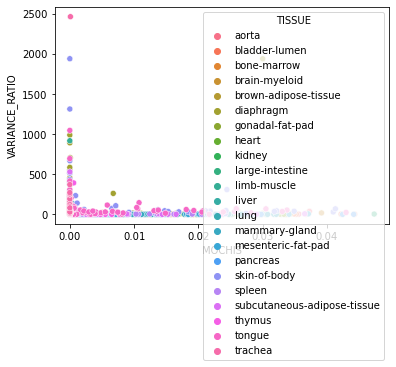

In [17]:
sns.scatterplot(data=df_3_18, x='MOCHIS', y='VARIANCE_RATIO', hue='TISSUE')

<AxesSubplot:xlabel='MOCHIS', ylabel='VARIANCE_RATIO'>

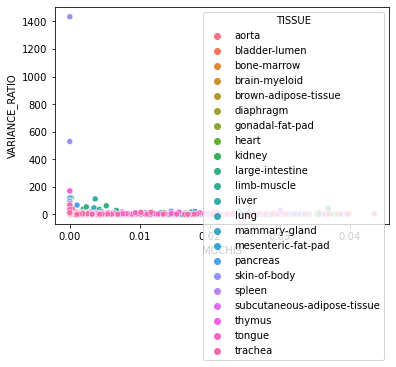

In [18]:
sns.scatterplot(data=df_18_24, x='MOCHIS', y='VARIANCE_RATIO', hue='TISSUE')

<AxesSubplot:xlabel='MOCHIS', ylabel='VARIANCE_RATIO'>

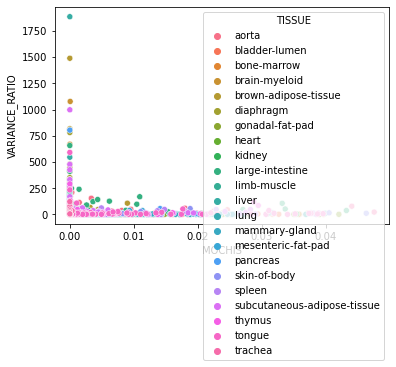

In [19]:
sns.scatterplot(data=df_24_3, x='MOCHIS', y='VARIANCE_RATIO', hue='TISSUE')

Next we look at the distribution, across tissues, of MOCHIS significant genes.

In [20]:
print("No. MOCHIS significant genes for 3m vs 18m: ", df_3_18.shape[0])
print("No. MOCHIS significant genes for 18m vs 24m: ", df_18_24.shape[0])
print("No. MOCHIS significant genes for 24m vs 3m: ", df_24_3.shape[0])




No. MOCHIS significant genes for 3m vs 18m:  5732
No. MOCHIS significant genes for 18m vs 24m:  4761
No. MOCHIS significant genes for 24m vs 3m:  5479


<AxesSubplot:ylabel='None'>

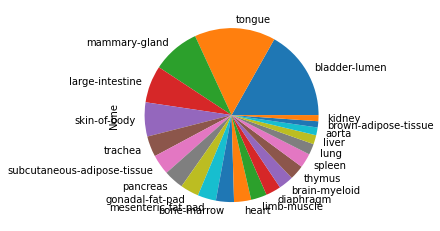

In [21]:
df_3_18.value_counts("TISSUE").plot(kind="pie")

<AxesSubplot:ylabel='None'>

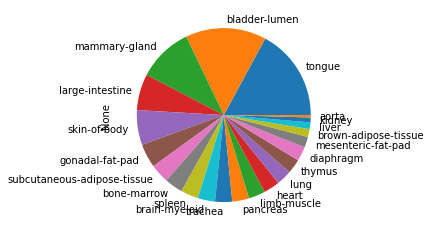

In [22]:
df_18_24.value_counts("TISSUE").plot(kind="pie")

<AxesSubplot:ylabel='None'>

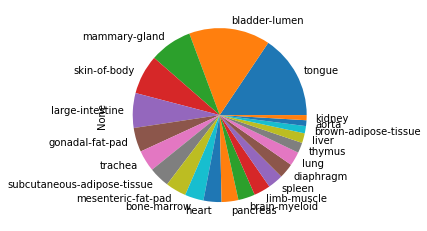

In [23]:
df_24_3.value_counts("TISSUE").plot(kind="pie")

## 2.3 Impact of Tie Breaking on Mann-Whitney DEGs

In Section 2.2, we raised the issue of tie breaking potentially affecting the significance of Mann-Whitney DEGs. Here, we check for difference between post-contaminated Mann-Whitney DEGs (this Section) and original DEGs (Section 2.1).

In [24]:
tissue_transcript_3_18 = pd.DataFrame(columns=['TRANSCRIPT', 'NEW_MANN_WHITNEY', 'TISSUE'])
tissue_transcript_18_24 = pd.DataFrame(columns=['TRANSCRIPT', 'NEW_MANN_WHITNEY', 'TISSUE'])
tissue_transcript_24_3 = pd.DataFrame(columns=['TRANSCRIPT', 'NEW_MANN_WHITNEY', 'TISSUE'])

for tissue in all_tissues:
    print("Reading in summary of p-values and ratios of variances for ", tissue)
    
    tissue_mann_whitney_df = pd.read_csv("tissues/"+tissue+"/mochis_p_val_table.csv")
    
    # Pick genes where one of the three pairs (3m, 18m, 24m) has significant p-value at FDR 0.05 control
    selected_genes_3_18 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MW_3_18']) <= 0.05]
    selected_genes_3_18 = selected_genes_3_18[["TRANSCRIPT", "MW_3_18"]]
    selected_genes_3_18= selected_genes_3_18.rename(columns={"MW_3_18":"NEW_MANN_WHITNEY"})
    selected_genes_3_18["TISSUE"] = [tissue for i in range(selected_genes_3_18.shape[0])]
    tissue_transcript_3_18 = pd.concat([tissue_transcript_3_18, selected_genes_3_18])
    
    selected_genes_18_24 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MW_18_24']) <= 0.05]
    selected_genes_18_24 = selected_genes_18_24[["TRANSCRIPT", "MW_18_24"]]
    selected_genes_18_24= selected_genes_18_24.rename(columns={"MW_18_24":"NEW_MANN_WHITNEY"})
    selected_genes_18_24["TISSUE"] = [tissue for i in range(selected_genes_18_24.shape[0])]
    tissue_transcript_18_24 = pd.concat([tissue_transcript_18_24, selected_genes_18_24])
    
    selected_genes_24_3 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MW_24_3']) <= 0.05]
    selected_genes_24_3 = selected_genes_24_3[["TRANSCRIPT", "MW_24_3"]]
    selected_genes_24_3 = selected_genes_24_3.rename(columns={"MW_24_3":"NEW_MANN_WHITNEY"})
    selected_genes_24_3["TISSUE"] = [tissue for i in range(selected_genes_24_3.shape[0])]
    tissue_transcript_24_3 = pd.concat([tissue_transcript_24_3, selected_genes_24_3])

# Compare against original MW significant genes
og_transcript_3_18 = pd.read_csv("tissues/mw_sig_3m_18m.csv")
og_transcript_18_24 = pd.read_csv("tissues/mw_sig_18m_24m.csv")
og_transcript_24_3 = pd.read_csv("tissues/mw_sig_24m_3m.csv")



Reading in summary of p-values and ratios of variances for  aorta
Reading in summary of p-values and ratios of variances for  bladder-lumen
Reading in summary of p-values and ratios of variances for  bone-marrow
Reading in summary of p-values and ratios of variances for  brain-myeloid
Reading in summary of p-values and ratios of variances for  brown-adipose-tissue
Reading in summary of p-values and ratios of variances for  diaphragm
Reading in summary of p-values and ratios of variances for  gonadal-fat-pad
Reading in summary of p-values and ratios of variances for  heart
Reading in summary of p-values and ratios of variances for  kidney
Reading in summary of p-values and ratios of variances for  large-intestine
Reading in summary of p-values and ratios of variances for  limb-muscle
Reading in summary of p-values and ratios of variances for  liver
Reading in summary of p-values and ratios of variances for  lung
Reading in summary of p-values and ratios of variances for  mammary-gland
R

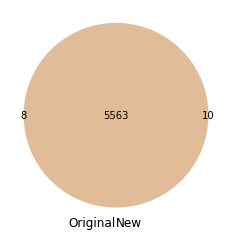

In [26]:
set1 = set(og_transcript_3_18['TRANSCRIPT'] + "_" + og_transcript_3_18['TISSUE'])
set2 = set(tissue_transcript_3_18['TRANSCRIPT'] + "_" + tissue_transcript_3_18['TISSUE'])
venn2([set1, set2], set_labels = ('Original', 'New'))


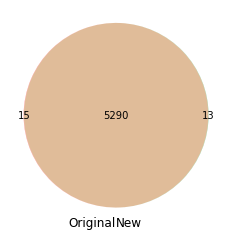

In [27]:
# Compare 24m vs 3m
set1 = set(og_transcript_18_24['TRANSCRIPT'] + "_" + og_transcript_18_24['TISSUE'])
set2 = set(tissue_transcript_18_24['TRANSCRIPT'] + "_" + tissue_transcript_18_24['TISSUE'])
venn2([set1, set2], set_labels = ('Original', 'New'))

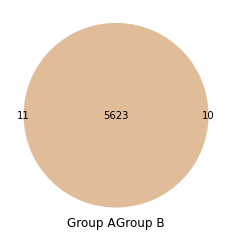

In [28]:
# Compare 24m vs 3m
set1 = set(og_transcript_24_3['TRANSCRIPT'] + "_" + og_transcript_24_3['TISSUE'])
set2 = set(tissue_transcript_24_3['TRANSCRIPT'] + "_" + tissue_transcript_24_3['TISSUE'])
venn2([set1, set2], set_labels = ('Group A', 'Group B'))

We see that there are very few original Mann-Whitney DEGs that are no longer significant after tie breaking, and conversely there are also very few new Mann-Whitney DEGs that were originally non-significant. This suggests that the tie-breaking procedure hardly affected the gene expression distributions between age groups.

# 3 Analysis

We examine more closely the differences between Mann-Whitney DEGs and MOCHIS DEGs. Recall that Mann-Whitney DEGs are genes that are typically picked up by standard differential analysis routines, whereas MOCHIS DEGs are genes that are differentially expressed owing to shifts in dispersion. Below, we perform some analyses to answer the following questions.

• How many MOCHIS DEGs were previously not detected by Mann-Whitney?

• Does MOCHIS really pick up shifts in dispersion?

• Are there other interesting questions we may answer with our newly detected MOCHIS DEGs?

In [31]:
## Compare counts
# Load original DEGs from Section 2.1

og_transcript_3_18 = pd.read_csv("tissues/mw_sig_3m_18m.csv")
og_transcript_18_24 = pd.read_csv("tissues/mw_sig_18m_24m.csv")
og_transcript_24_3 = pd.read_csv("tissues/mw_sig_24m_3m.csv")

# Load MOCHIS DEGs from Section 2.2
tissue_transcript_3_18 = pd.read_csv("tissues/mochis_sig_3m_18m.csv")
tissue_transcript_18_24 = pd.read_csv("tissues/mochis_sig_18m_24m.csv")
tissue_transcript_24_3 = pd.read_csv("tissues/mochis_sig_24m_3m.csv")





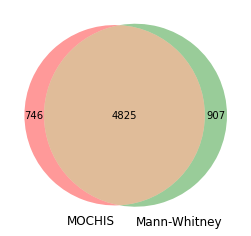

In [32]:
# Compare 3m vs 18m
set1 = set(og_transcript_3_18['TRANSCRIPT'] + "_" + og_transcript_3_18['TISSUE'])
set2 = set(tissue_transcript_3_18['TRANSCRIPT'] + "_" + tissue_transcript_3_18['TISSUE'])
venn2([set1, set2], set_labels = ('MOCHIS', 'Mann-Whitney'))

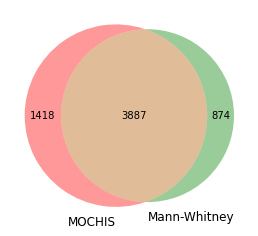

In [33]:
# Compare 18m vs 24m
set1 = set(og_transcript_18_24['TRANSCRIPT'] + "_" + og_transcript_18_24['TISSUE'])
set2 = set(tissue_transcript_18_24['TRANSCRIPT'] + "_" + tissue_transcript_18_24['TISSUE'])
venn2([set1, set2], set_labels = ('MOCHIS', 'Mann-Whitney'))



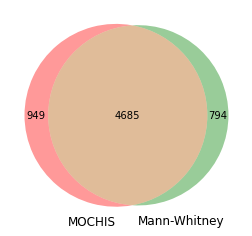

In [34]:
# Compare 3m vs 24m
set1 = set(og_transcript_24_3['TRANSCRIPT'] + "_" + og_transcript_24_3['TISSUE'])
set2 = set(tissue_transcript_24_3['TRANSCRIPT'] + "_" + tissue_transcript_24_3['TISSUE'])
venn2([set1, set2], set_labels = ('MOCHIS', 'Mann-Whitney'))



Summary of Findings


1. In general, there are considerable differences in the genes picked up by Mann-Whitney and MOCHIS. For any pair of age groups, MOCHIS picks up at least 750 DEGs that were not picked up by Mann-Whitney.

2. The number of new genes picked up by MOCHIS is the largest for the pair “3m vs 18m” (= 905), and smallest for the pair “3m vs 21m” (= 794).

3. The number of Mann-Whitney significant genes that are not MOCHIS significant is greatest for the pair “18m vs 24m” (= 1397) and smallest for the pair “3m vs 18m” (= 753).





## 3.2 Visualizing Changes in Dispersion

The skeptical reader may wonder if MOCHIS is really picking up a shift in dispersion between the two age groups. Since we realistically cannot compare gene expression distributions between age groups for each MOCHIS significant gene, here we show some gene expression visualizations of MOCHIS significant genes. We focus on MOCHIS DEGs that were not detected by Mann-Whitney. We show visualizations for each pair of age groups (“3m vs 18m”, “18m vs 24m” and “3m vs 24m”).

ENSMUSG00000032562 in aorta


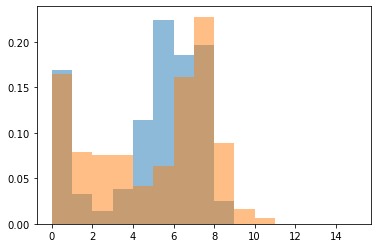

ENSMUSG00000020048 in bladder-lumen


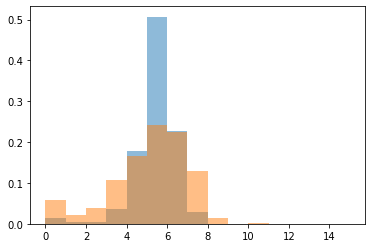

14517
ENSMUSG00000036438 in bone-marrow


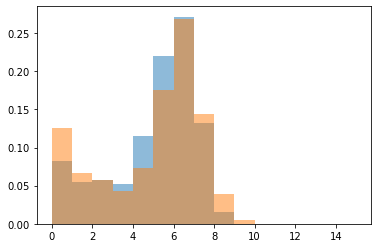

ENSMUSG00000029919 in brain-myeloid


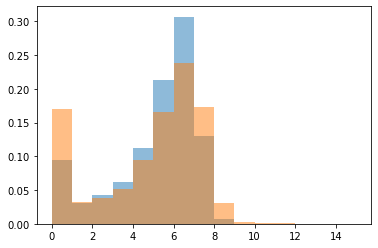

ENSMUSG00000027523 in heart


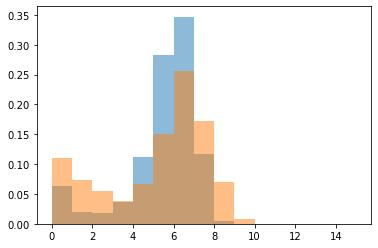

ENSMUSG00000027712 in pancreas


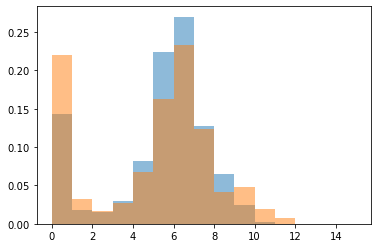

In [209]:
set1 = set(og_transcript_3_18['TRANSCRIPT'] + "_" + og_transcript_3_18['TISSUE'])
set2 = set(tissue_transcript_3_18['TRANSCRIPT'] + "_" + tissue_transcript_3_18['TISSUE'])
mochis_unique = pd.DataFrame()
for elem in set2:
    if elem not in set1:
        tc = elem.split("_")[0]
        ts = elem.split("_")[1]
        mochis_unique = pd.concat([mochis_unique, 
                                   tissue_transcript_3_18.loc[(tissue_transcript_3_18['TRANSCRIPT'] == tc) & (tissue_transcript_3_18['TISSUE'] == ts)]])
        mochis_unique.index = [i for i in range(1, len(mochis_unique)+1)]

# Pick genes by hand (I choose the ones with biggest variance ratio in each tissue)
curated_degs_df = pd.DataFrame()
mu_aorta = mochis_unique[mochis_unique['TISSUE']=='aorta']
curated_degs_df = pd.concat([curated_degs_df, mu_aorta[mu_aorta['VARIANCE_RATIO'] == max(mu_aorta['VARIANCE_RATIO'])]])
mu_bladder_lumen = mochis_unique[mochis_unique['TISSUE']=='bladder-lumen']
curated_degs_df = pd.concat([curated_degs_df, mu_bladder_lumen[mu_bladder_lumen['VARIANCE_RATIO'] == max(mu_bladder_lumen['VARIANCE_RATIO'])]])
mu_bone_marrow = mochis_unique[mochis_unique['TISSUE']=='bone-marrow']
curated_degs_df = pd.concat([curated_degs_df, mu_bone_marrow[mu_bone_marrow['VARIANCE_RATIO'] == max(mu_bone_marrow['VARIANCE_RATIO'])]])
mu_brain_myeloid = mochis_unique[mochis_unique['TISSUE']=='brain-myeloid']
curated_degs_df = pd.concat([curated_degs_df,mu_brain_myeloid[mu_brain_myeloid['VARIANCE_RATIO'] == max(mu_brain_myeloid['VARIANCE_RATIO'])]])
mu_heart = mochis_unique[mochis_unique['TISSUE']=='heart']
curated_degs_df = pd.concat([curated_degs_df,mu_heart[mu_heart['VARIANCE_RATIO'] == max(mu_heart['VARIANCE_RATIO'])]])
mu_pancreas = mochis_unique[mochis_unique['TISSUE']=='pancreas']
mu_pancreas[mu_pancreas['VARIANCE_RATIO'] == max(mu_pancreas['VARIANCE_RATIO'])]
curated_degs_df = pd.concat([curated_degs_df,mu_pancreas[mu_pancreas['VARIANCE_RATIO'] == max(mu_pancreas['VARIANCE_RATIO'])]])

# Generate plots
for i in range(len(curated_degs_df)):
    
    tissue = curated_degs_df.iloc[i]['TISSUE']
    transcript = curated_degs_df.iloc[i]['TRANSCRIPT']
    
    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].values)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
   
    this_gene_exp_level = pd.DataFrame({
        'TRANSCRIPT': smartseq2_raw_counts[:, np.where(transcripts==transcript)[0][0]],
        'AGE': ages
    })
    
    if tissue == 'bone-marrow':
        print(len(smartseq2_raw_counts))
    
    
    this_gene_exp_level_3m = this_gene_exp_level[this_gene_exp_level['AGE']=='3m']
    this_gene_exp_level_18m = this_gene_exp_level[this_gene_exp_level['AGE']=='18m']
    
    # Visualize
    

    bins = [i for i in range(16)]
    
    print(transcript + " in " + tissue)
    plt.hist([math.log(i+1) for i in this_gene_exp_level_3m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.hist([math.log(i+1) for i in this_gene_exp_level_18m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.show()
    
    
    #plt.legend(loc='upper right')
    
    




ENSMUSG00000058546 in aorta


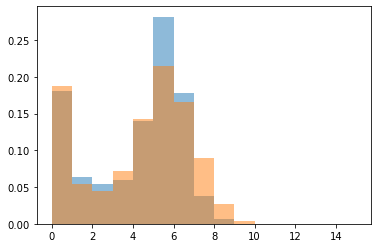

ENSMUSG00000018476 in bladder-lumen


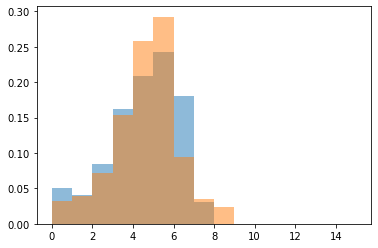

ENSMUSG00000022205 in bone-marrow


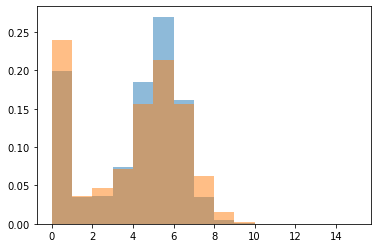

ENSMUSG00000071076 in diaphragm


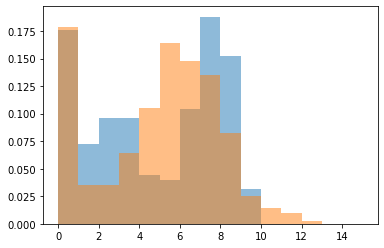

ENSMUSG00000090862 in large-intestine


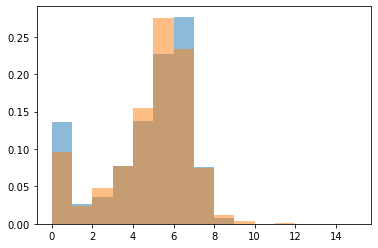

ENSMUSG00000025492 in limb-muscle


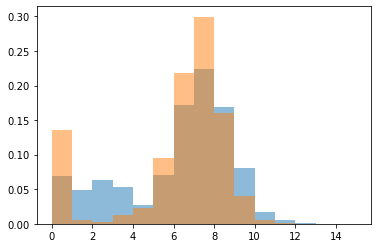

In [211]:
set1 = set(og_transcript_18_24['TRANSCRIPT'] + "_" + og_transcript_18_24['TISSUE'])
set2 = set(tissue_transcript_18_24['TRANSCRIPT'] + "_" + tissue_transcript_18_24['TISSUE'])
mochis_unique = pd.DataFrame()
for elem in set2:
    if elem not in set1:
        tc = elem.split("_")[0]
        ts = elem.split("_")[1]
        mochis_unique = pd.concat([mochis_unique, 
                                   tissue_transcript_18_24.loc[(tissue_transcript_18_24['TRANSCRIPT'] == tc) & (tissue_transcript_18_24['TISSUE'] == ts)]])
        mochis_unique.index = [i for i in range(1, len(mochis_unique)+1)]
        

# Pick genes by hand (I choose the ones with biggest variance ratio in each tissue)
curated_degs_df = pd.DataFrame()
mu_aorta = mochis_unique[mochis_unique['TISSUE']=='aorta']
curated_degs_df = pd.concat([curated_degs_df, mu_aorta[mu_aorta['VARIANCE_RATIO'] == max(mu_aorta['VARIANCE_RATIO'])]])
mu_bladder_lumen = mochis_unique[mochis_unique['TISSUE']=='bladder-lumen']
curated_degs_df = pd.concat([curated_degs_df, mu_bladder_lumen[mu_bladder_lumen['VARIANCE_RATIO'] == max(mu_bladder_lumen['VARIANCE_RATIO'])]])
mu_bone_marrow = mochis_unique[mochis_unique['TISSUE']=='bone-marrow']
curated_degs_df = pd.concat([curated_degs_df, mu_bone_marrow[mu_bone_marrow['VARIANCE_RATIO'] == max(mu_bone_marrow['VARIANCE_RATIO'])]])
mu_diaphragm = mochis_unique[mochis_unique['TISSUE']=='diaphragm']
curated_degs_df = pd.concat([curated_degs_df,mu_diaphragm[mu_diaphragm['VARIANCE_RATIO'] == max(mu_diaphragm['VARIANCE_RATIO'])]])
mu_large_intestine = mochis_unique[mochis_unique['TISSUE']=='large-intestine']
curated_degs_df = pd.concat([curated_degs_df,mu_large_intestine[mu_large_intestine['VARIANCE_RATIO'] == max(mu_large_intestine['VARIANCE_RATIO'])]])
mu_limb_muscle = mochis_unique[mochis_unique['TISSUE']=='limb-muscle']
mu_limb_muscle[mu_limb_muscle['VARIANCE_RATIO'] == max(mu_limb_muscle['VARIANCE_RATIO'])]
curated_degs_df = pd.concat([curated_degs_df,mu_limb_muscle[mu_limb_muscle['VARIANCE_RATIO'] == max(mu_limb_muscle['VARIANCE_RATIO'])]])


# Generate plots
for i in range(len(curated_degs_df)):
    tissue = curated_degs_df.iloc[i]['TISSUE']
    transcript = curated_degs_df.iloc[i]['TRANSCRIPT']
    
    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].values)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
   
    this_gene_exp_level = pd.DataFrame({
        'TRANSCRIPT': smartseq2_raw_counts[:, np.where(transcripts==transcript)[0][0]],
        'AGE': ages
    })
    
    
    this_gene_exp_level_18m = this_gene_exp_level[this_gene_exp_level['AGE']=='18m']
    this_gene_exp_level_24m = this_gene_exp_level[this_gene_exp_level['AGE']=='24m']
    
    # Visualize
    

    bins = [i for i in range(16)]
    
    
    print(transcript + " in " + tissue)
    plt.hist([math.log(i+1) for i in this_gene_exp_level_18m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.hist([math.log(i+1) for i in this_gene_exp_level_24m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.show()
    
    
    #plt.legend(loc='upper right')
    
    




ENSMUSG00000020745 in bladder-lumen


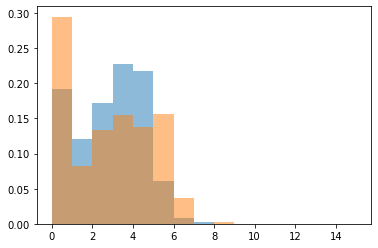

ENSMUSG00000022205 in bone-marrow


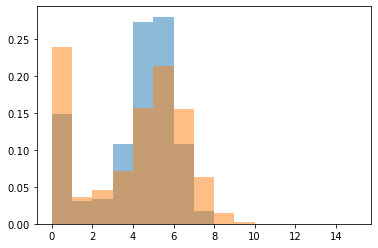

ENSMUSG00000000326 in brain-myeloid


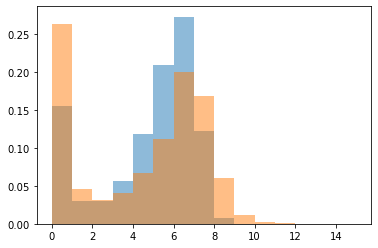

ENSMUSG00000056201 in brown-adipose-tissue


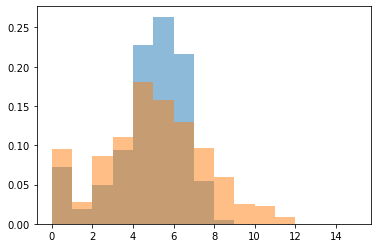

ENSMUSG00000030067 in spleen


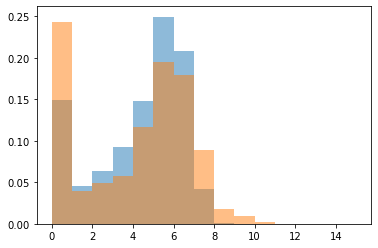

ENSMUSG00000050708 in thymus


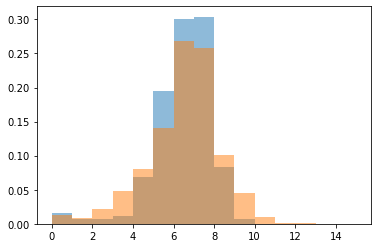

In [212]:
set1 = set(og_transcript_24_3['TRANSCRIPT'] + "_" + og_transcript_24_3['TISSUE'])
set2 = set(tissue_transcript_24_3['TRANSCRIPT'] + "_" + tissue_transcript_24_3['TISSUE'])
mochis_unique = pd.DataFrame()
for elem in set2:
    if elem not in set1:
        tc = elem.split("_")[0]
        ts = elem.split("_")[1]
        mochis_unique = pd.concat([mochis_unique, 
                                   tissue_transcript_24_3.loc[(tissue_transcript_24_3['TRANSCRIPT'] == tc) & (tissue_transcript_24_3['TISSUE'] == ts)]])
        mochis_unique.index = [i for i in range(1, len(mochis_unique)+1)]
        

# Pick genes by hand (I choose the ones with biggest variance ratio in each tissue)
curated_degs_df = pd.DataFrame()

mu_bladder_lumen = mochis_unique[mochis_unique['TISSUE']=='bladder-lumen']
curated_degs_df = pd.concat([curated_degs_df, mu_bladder_lumen[mu_bladder_lumen['VARIANCE_RATIO'] == max(mu_bladder_lumen['VARIANCE_RATIO'])]])

mu_bone_marrow = mochis_unique[mochis_unique['TISSUE']=='bone-marrow']
curated_degs_df = pd.concat([curated_degs_df, mu_bone_marrow[mu_bone_marrow['VARIANCE_RATIO'] == max(mu_bone_marrow['VARIANCE_RATIO'])]])

mu_brain_myeloid = mochis_unique[mochis_unique['TISSUE']=='brain-myeloid']
curated_degs_df = pd.concat([curated_degs_df, mu_brain_myeloid[mu_brain_myeloid['VARIANCE_RATIO'] == max(mu_brain_myeloid['VARIANCE_RATIO'])]])

mu_brown_adipose_tissue = mochis_unique[mochis_unique['TISSUE']=='brown-adipose-tissue']
curated_degs_df = pd.concat([curated_degs_df,mu_brown_adipose_tissue[mu_brown_adipose_tissue['VARIANCE_RATIO'] == max(mu_brown_adipose_tissue['VARIANCE_RATIO'])]])

mu_spleen = mochis_unique[mochis_unique['TISSUE']=='spleen']
curated_degs_df = pd.concat([curated_degs_df,mu_spleen[mu_spleen['VARIANCE_RATIO'] == max(mu_spleen['VARIANCE_RATIO'])]])
mu_thymus = mochis_unique[mochis_unique['TISSUE']=='thymus']
curated_degs_df = pd.concat([curated_degs_df,mu_thymus[mu_thymus['VARIANCE_RATIO'] == max(mu_thymus['VARIANCE_RATIO'])]])


# Generate plots
for i in range(len(curated_degs_df)):
    tissue = curated_degs_df.iloc[i]['TISSUE']
    transcript = curated_degs_df.iloc[i]['TRANSCRIPT']
    
    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].values)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
   
    this_gene_exp_level = pd.DataFrame({
        'TRANSCRIPT': smartseq2_raw_counts[:, np.where(transcripts==transcript)[0][0]],
        'AGE': ages
    })
    
    
    this_gene_exp_level_3m = this_gene_exp_level[this_gene_exp_level['AGE']=='3m']
    this_gene_exp_level_24m = this_gene_exp_level[this_gene_exp_level['AGE']=='24m']
    
    # Visualize
    

    bins = [i for i in range(16)]
    
    
    print(transcript + " in " + tissue)
    plt.hist([math.log(i+1) for i in this_gene_exp_level_3m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.hist([math.log(i+1) for i in this_gene_exp_level_24m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.show()
    
    
    #plt.legend(loc='upper right')
    
    




#### Summary of Findings

We find that

1. MOCHIS detects shifts in dispersions. These shifts can be in either direction (positive or negative). 

2. Some of the shifts can be attributed to more pronounced zero inflation in one age group than another (based on post-analysis visualizations). This raises an important caveat in our analysis, namely, that our first step of filtering out genes that have more than 20% zero-inflation rate effectively removes all contribution by technical noise to the data. If we are skeptical, then we must find other ways to effectively remove contribution by technical noise.
